In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.2
seed 0
2023-08-22 06:35:29.743745


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-11.2688)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(18.2626)
penalty_target_min tensor(-11.0894) penalty_target_max tensor(4.8982)
train_loss:  -7.708873830413817
valid_loss:  -6.822843373870849
h_min_tilde -11.089354 ell_tilde -7.531667739105224 kappa_tilde 0.0002650856434583682


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.9073486328125e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 7.046233654022217

 2 6.970252752304077

 3 3.895691394805908

 4 3.971125364303589

 5 3.658923864364624

 6 3.542908191680908

 7 3.55114483833313

 8 3.5041513442993164

 9 3.580036163330078

 10 5.000699520111084

 11 7.355204343795776

 12 6.447803020477295

 13 7.479138612747192

 14 6.851491451263428

 15 4.710300922393799

 16 7.305980443954468

 17 7.2557783126831055

 18 3.6987509727478027

 19 3.970693349838257

 20 3.716038227081299

 21 3.4751052856445312

 22 3.7300949096679688

 23 3.5043137073516846

 24 3.559635639190674

 25 3.644239902496338

 26 3.627779722213745

 27 3.79410457611084

 28 5.0360329151153564

 29 5.931589603424072

 30 6.947742700576782

 31 4.407902717590332

 32 5.07204794883728

 33 7.354741334915161

 34 3.9386940002441406

 35 3.696580648422241

 36 4.382229804992676

 37 3.5940346717834473

 38 3.5996034145355225

 39 3.9376907348632812

 40 3.59275484085083

 41 3.4436018466949463

 42 3.773775100708008

 43 6.783221960067749

 44 7.33560

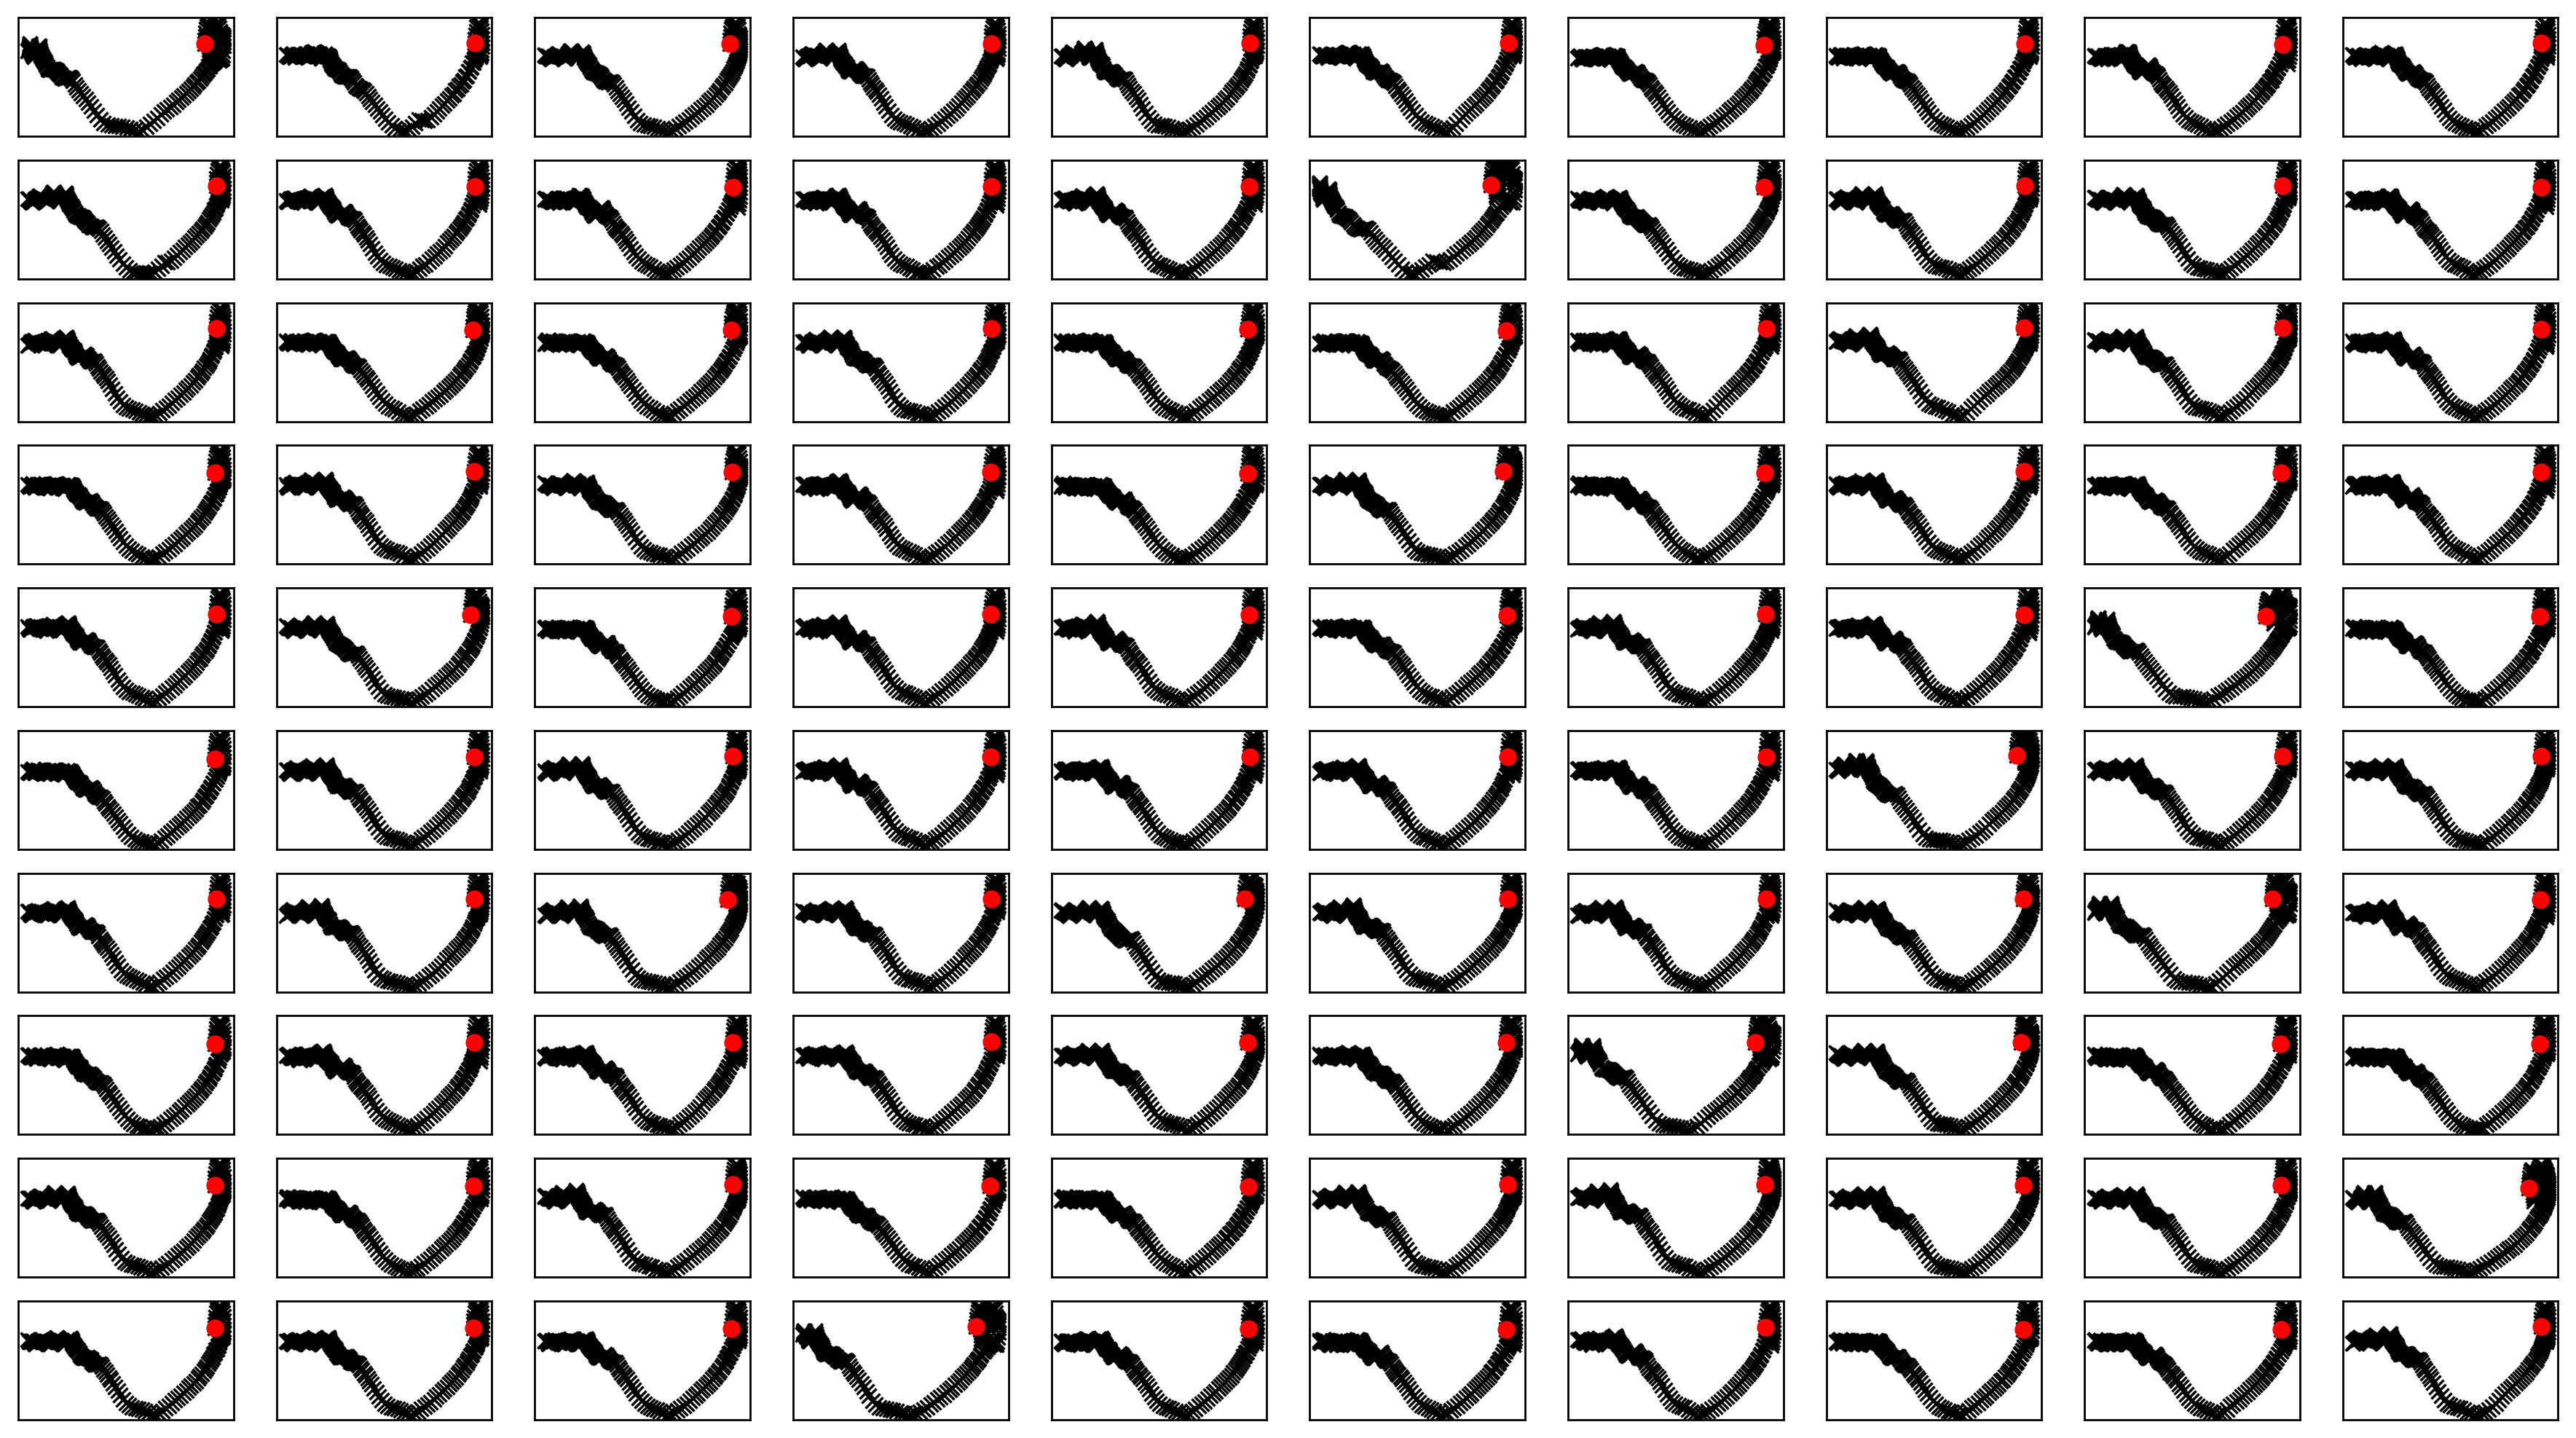

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

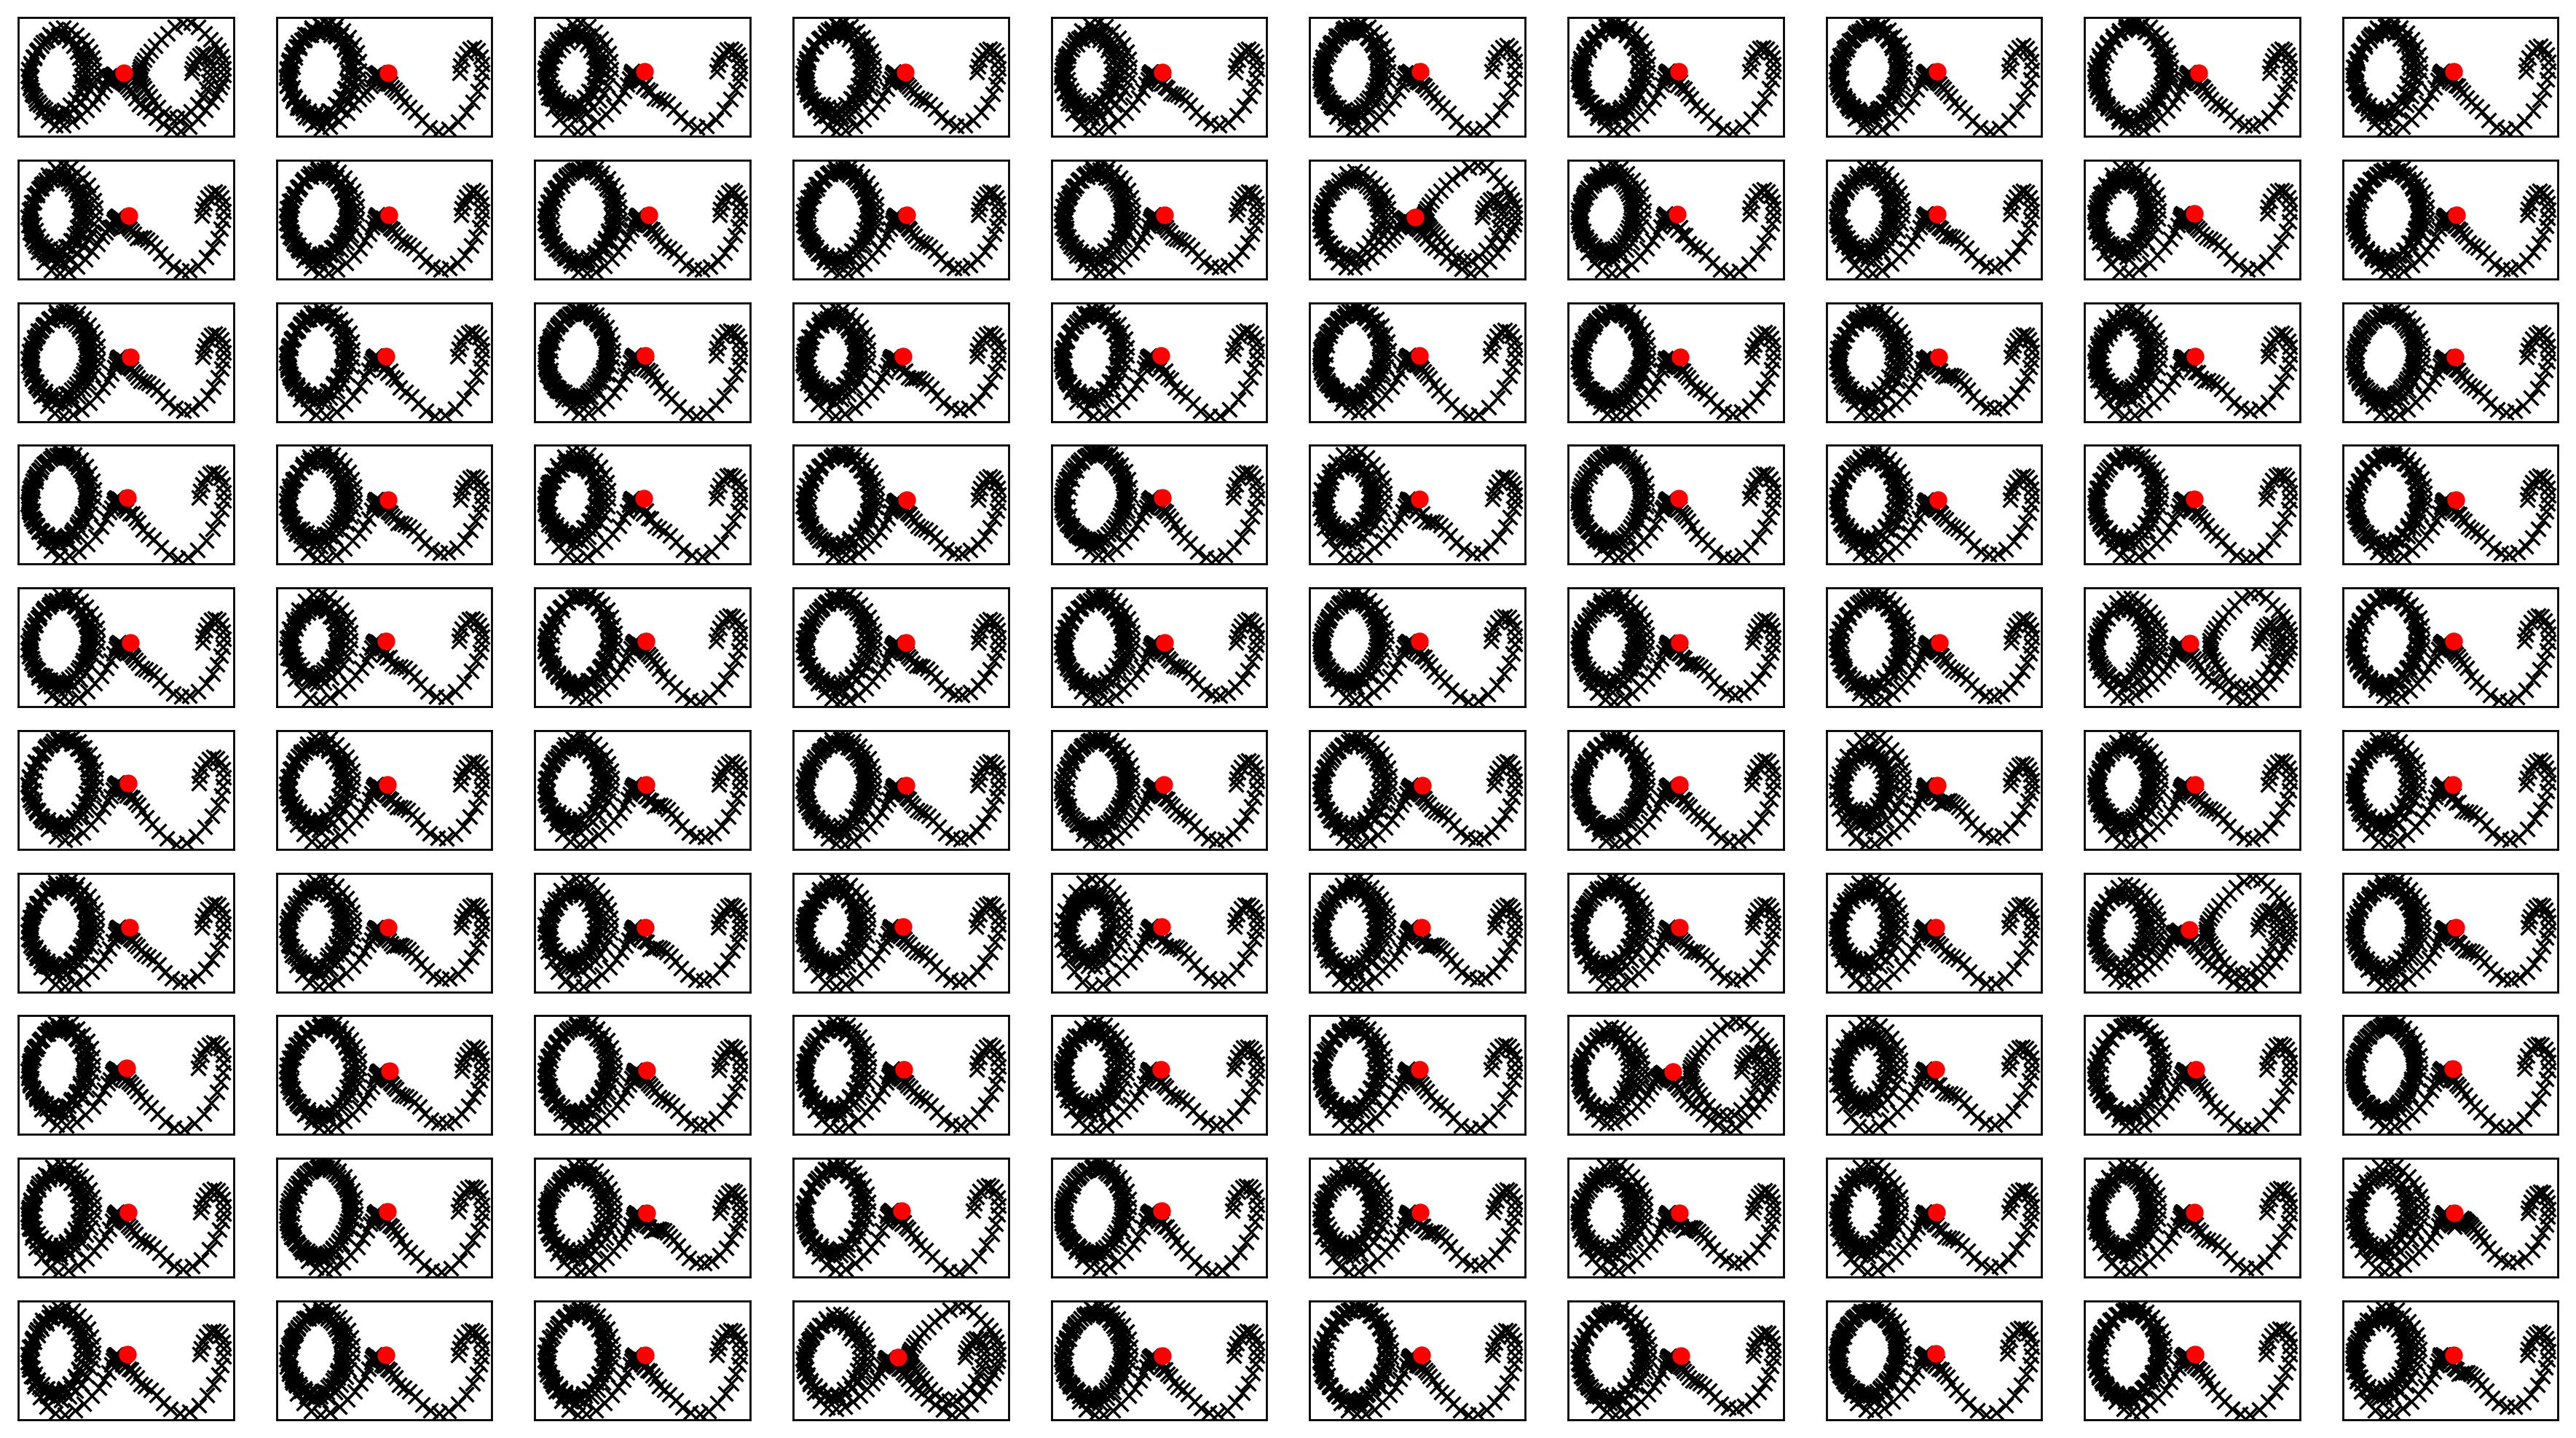

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
# plt.show()
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")

In [8]:
print(datetime.datetime.now())

2023-08-22 06:44:17.981987


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.35139  validloss 1.41848±0.00000  bestvalidloss 1.41848  last_update 0
train: iter 1  trainloss 1.25408  validloss 1.26053±0.00000  bestvalidloss 1.26053  last_update 0
train: iter 2  trainloss 1.13864  validloss 1.10126±0.00000  bestvalidloss 1.10126  last_update 0
train: iter 3  trainloss 1.04539  validloss 0.95888±0.00000  bestvalidloss 0.95888  last_update 0
train: iter 4  trainloss 0.95683  validloss 0.88189±0.00000  bestvalidloss 0.88189  last_update 0
train: iter 5  trainloss 0.89075  validloss 0.79390±0.00000  bestvalidloss 0.79390  last_update 0
train: iter 6  trainloss 0.83219  validloss 0.75529±0.00000  bestvalidloss 0.75529  last_update 0
train: iter 7  trainloss 0.79317  validloss 0.69059±0.00000  bestvalidloss 0.69059  last_update 0
train: iter 8  trainloss 0.75874  validloss 0.66305±0.00000  bestvalidloss 0.66305  last_update 0
train: iter 9  trainloss 0.72644  validloss 0.62341±0.00000  bestvalidloss 0.62341  last_update 0
train: iter 10  trai

train: iter 84  trainloss 0.39815  validloss 0.35659±0.00000  bestvalidloss 0.33962  last_update 4
train: iter 85  trainloss 0.39767  validloss 0.34027±0.00000  bestvalidloss 0.33962  last_update 5
train: iter 86  trainloss 0.39971  validloss 0.33726±0.00000  bestvalidloss 0.33726  last_update 0
train: iter 87  trainloss 0.39518  validloss 0.34252±0.00000  bestvalidloss 0.33726  last_update 1
train: iter 88  trainloss 0.39162  validloss 0.33957±0.00000  bestvalidloss 0.33726  last_update 2
train: iter 89  trainloss 0.39283  validloss 0.34092±0.00000  bestvalidloss 0.33726  last_update 3
train: iter 90  trainloss 0.40591  validloss 0.33312±0.00000  bestvalidloss 0.33312  last_update 0
train: iter 91  trainloss 0.39737  validloss 0.35176±0.00000  bestvalidloss 0.33312  last_update 1
train: iter 92  trainloss 0.38682  validloss 0.34825±0.00000  bestvalidloss 0.33312  last_update 2
train: iter 93  trainloss 0.39347  validloss 0.35009±0.00000  bestvalidloss 0.33312  last_update 3
train: ite

train: iter 167  trainloss 0.34665  validloss 0.30563±0.00000  bestvalidloss 0.29577  last_update 1
train: iter 168  trainloss 0.35361  validloss 0.33691±0.00000  bestvalidloss 0.29577  last_update 2
train: iter 169  trainloss 0.34361  validloss 0.29386±0.00000  bestvalidloss 0.29386  last_update 0
train: iter 170  trainloss 0.35189  validloss 0.29383±0.00000  bestvalidloss 0.29383  last_update 0
train: iter 171  trainloss 0.35202  validloss 0.29959±0.00000  bestvalidloss 0.29383  last_update 1
train: iter 172  trainloss 0.34328  validloss 0.29940±0.00000  bestvalidloss 0.29383  last_update 2
train: iter 173  trainloss 0.34564  validloss 0.31185±0.00000  bestvalidloss 0.29383  last_update 3
train: iter 174  trainloss 0.35055  validloss 0.29073±0.00000  bestvalidloss 0.29073  last_update 0
train: iter 175  trainloss 0.34803  validloss 0.29301±0.00000  bestvalidloss 0.29073  last_update 1
train: iter 176  trainloss 0.35231  validloss 0.29497±0.00000  bestvalidloss 0.29073  last_update 2


train: iter 249  trainloss 0.32296  validloss 0.26650±0.00000  bestvalidloss 0.26650  last_update 0
train: iter 250  trainloss 0.32087  validloss 0.26898±0.00000  bestvalidloss 0.26650  last_update 1
train: iter 251  trainloss 0.32300  validloss 0.27398±0.00000  bestvalidloss 0.26650  last_update 2
train: iter 252  trainloss 0.31409  validloss 0.27036±0.00000  bestvalidloss 0.26650  last_update 3
train: iter 253  trainloss 0.32376  validloss 0.27476±0.00000  bestvalidloss 0.26650  last_update 4
train: iter 254  trainloss 0.31559  validloss 0.28193±0.00000  bestvalidloss 0.26650  last_update 5
train: iter 255  trainloss 0.31830  validloss 0.26980±0.00000  bestvalidloss 0.26650  last_update 6
train: iter 256  trainloss 0.32442  validloss 0.27740±0.00000  bestvalidloss 0.26650  last_update 7
train: iter 257  trainloss 0.31304  validloss 0.27384±0.00000  bestvalidloss 0.26650  last_update 8
train: iter 258  trainloss 0.31552  validloss 0.29639±0.00000  bestvalidloss 0.26650  last_update 9


train: iter 331  trainloss 0.29466  validloss 0.26755±0.00000  bestvalidloss 0.25014  last_update 16
train: iter 332  trainloss 0.29746  validloss 0.24941±0.00000  bestvalidloss 0.24941  last_update 0
train: iter 333  trainloss 0.29608  validloss 0.25857±0.00000  bestvalidloss 0.24941  last_update 1
train: iter 334  trainloss 0.30361  validloss 0.27793±0.00000  bestvalidloss 0.24941  last_update 2
train: iter 335  trainloss 0.29688  validloss 0.25190±0.00000  bestvalidloss 0.24941  last_update 3
train: iter 336  trainloss 0.29825  validloss 0.26054±0.00000  bestvalidloss 0.24941  last_update 4
train: iter 337  trainloss 0.29695  validloss 0.25039±0.00000  bestvalidloss 0.24941  last_update 5
train: iter 338  trainloss 0.29177  validloss 0.24930±0.00000  bestvalidloss 0.24930  last_update 0
train: iter 339  trainloss 0.31259  validloss 0.27921±0.00000  bestvalidloss 0.24930  last_update 1
train: iter 340  trainloss 0.30466  validloss 0.29039±0.00000  bestvalidloss 0.24930  last_update 2

train: iter 413  trainloss 0.29973  validloss 0.24604±0.00000  bestvalidloss 0.24129  last_update 40
train: iter 414  trainloss 0.28481  validloss 0.25090±0.00000  bestvalidloss 0.24129  last_update 41
train: iter 415  trainloss 0.28336  validloss 0.26220±0.00000  bestvalidloss 0.24129  last_update 42
train: iter 416  trainloss 0.28106  validloss 0.24818±0.00000  bestvalidloss 0.24129  last_update 43
train: iter 417  trainloss 0.28256  validloss 0.24360±0.00000  bestvalidloss 0.24129  last_update 44
train: iter 418  trainloss 0.28285  validloss 0.24766±0.00000  bestvalidloss 0.24129  last_update 45
train: iter 419  trainloss 0.28474  validloss 0.24474±0.00000  bestvalidloss 0.24129  last_update 46
train: iter 420  trainloss 0.28151  validloss 0.25048±0.00000  bestvalidloss 0.24129  last_update 47
train: iter 421  trainloss 0.27867  validloss 0.24930±0.00000  bestvalidloss 0.24129  last_update 48
train: iter 422  trainloss 0.28117  validloss 0.25297±0.00000  bestvalidloss 0.24129  last_

train: iter 495  trainloss 0.26578  validloss 0.25622±0.00000  bestvalidloss 0.24114  last_update 52
train: iter 496  trainloss 0.26944  validloss 0.25359±0.00000  bestvalidloss 0.24114  last_update 53
train: iter 497  trainloss 0.26915  validloss 0.24228±0.00000  bestvalidloss 0.24114  last_update 54
train: iter 498  trainloss 0.27250  validloss 0.24853±0.00000  bestvalidloss 0.24114  last_update 55
train: iter 499  trainloss 0.26757  validloss 0.25551±0.00000  bestvalidloss 0.24114  last_update 56
train: iter 500  trainloss 0.26858  validloss 0.25319±0.00000  bestvalidloss 0.24114  last_update 57
train: iter 501  trainloss 0.26833  validloss 0.24965±0.00000  bestvalidloss 0.24114  last_update 58
train: iter 502  trainloss 0.27691  validloss 0.26463±0.00000  bestvalidloss 0.24114  last_update 59
train: iter 503  trainloss 0.26867  validloss 0.24230±0.00000  bestvalidloss 0.24114  last_update 60
train: iter 504  trainloss 0.27006  validloss 0.24790±0.00000  bestvalidloss 0.24114  last_

train: iter 577  trainloss 0.26023  validloss 0.25287±0.00000  bestvalidloss 0.23982  last_update 54
train: iter 578  trainloss 0.26039  validloss 0.24804±0.00000  bestvalidloss 0.23982  last_update 55
train: iter 579  trainloss 0.25841  validloss 0.25405±0.00000  bestvalidloss 0.23982  last_update 56
train: iter 580  trainloss 0.25965  validloss 0.24447±0.00000  bestvalidloss 0.23982  last_update 57
train: iter 581  trainloss 0.25781  validloss 0.24449±0.00000  bestvalidloss 0.23982  last_update 58
train: iter 582  trainloss 0.26542  validloss 0.24009±0.00000  bestvalidloss 0.23982  last_update 59
train: iter 583  trainloss 0.26653  validloss 0.25005±0.00000  bestvalidloss 0.23982  last_update 60
train: iter 584  trainloss 0.25792  validloss 0.26524±0.00000  bestvalidloss 0.23982  last_update 61
train: iter 585  trainloss 0.25920  validloss 0.24843±0.00000  bestvalidloss 0.23982  last_update 62
train: iter 586  trainloss 0.25939  validloss 0.24568±0.00000  bestvalidloss 0.23982  last_

train: iter 659  trainloss 0.25924  validloss 0.24431±0.00000  bestvalidloss 0.23560  last_update 11
train: iter 660  trainloss 0.25297  validloss 0.23808±0.00000  bestvalidloss 0.23560  last_update 12
train: iter 661  trainloss 0.25240  validloss 0.25191±0.00000  bestvalidloss 0.23560  last_update 13
train: iter 662  trainloss 0.25410  validloss 0.25034±0.00000  bestvalidloss 0.23560  last_update 14
train: iter 663  trainloss 0.25171  validloss 0.24219±0.00000  bestvalidloss 0.23560  last_update 15
train: iter 664  trainloss 0.25123  validloss 0.25511±0.00000  bestvalidloss 0.23560  last_update 16
train: iter 665  trainloss 0.25565  validloss 0.25040±0.00000  bestvalidloss 0.23560  last_update 17
train: iter 666  trainloss 0.25123  validloss 0.24348±0.00000  bestvalidloss 0.23560  last_update 18
train: iter 667  trainloss 0.25225  validloss 0.24443±0.00000  bestvalidloss 0.23560  last_update 19
train: iter 668  trainloss 0.25137  validloss 0.25240±0.00000  bestvalidloss 0.23560  last_

train: iter 741  trainloss 0.24911  validloss 0.24400±0.00000  bestvalidloss 0.23304  last_update 20
train: iter 742  trainloss 0.24435  validloss 0.23392±0.00000  bestvalidloss 0.23304  last_update 21
train: iter 743  trainloss 0.24770  validloss 0.23418±0.00000  bestvalidloss 0.23304  last_update 22
train: iter 744  trainloss 0.24756  validloss 0.24948±0.00000  bestvalidloss 0.23304  last_update 23
train: iter 745  trainloss 0.24683  validloss 0.24542±0.00000  bestvalidloss 0.23304  last_update 24
train: iter 746  trainloss 0.24661  validloss 0.24360±0.00000  bestvalidloss 0.23304  last_update 25
train: iter 747  trainloss 0.25100  validloss 0.23489±0.00000  bestvalidloss 0.23304  last_update 26
train: iter 748  trainloss 0.24683  validloss 0.23851±0.00000  bestvalidloss 0.23304  last_update 27
train: iter 749  trainloss 0.24751  validloss 0.25447±0.00000  bestvalidloss 0.23304  last_update 28
train: iter 750  trainloss 0.24374  validloss 0.24534±0.00000  bestvalidloss 0.23304  last_

train_loss:  -2.9033321986645464
valid_loss:  -3.0883963039278983
weight_alpha 1.0 h_min_tilde -11.089354 ell_tilde -2.940345019717217 kappa_tilde 0.00017515301514841575
train_loss:  -2.088724449181557
valid_loss:  -1.635571214580536
weight_alpha 0.2 h_min_tilde -11.089354 ell_tilde -1.9980938022613526 kappa_tilde 0.00016582804126418909


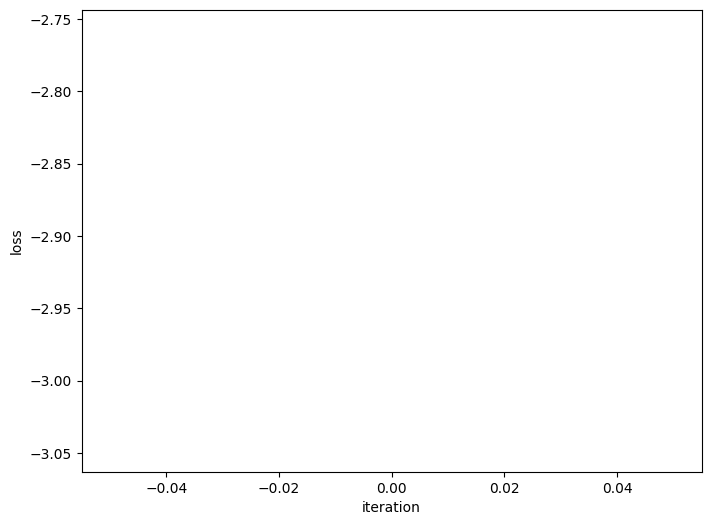

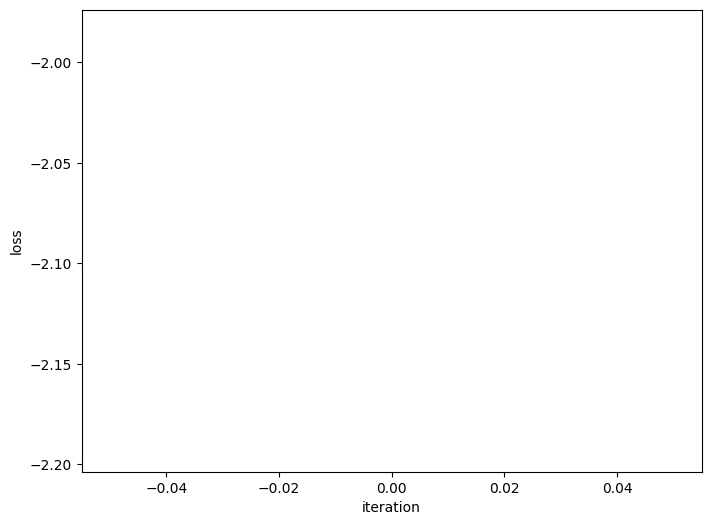

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -398.74125  validloss -330.11873±0.00000  bestvalidloss -330.11873  last_update 0
train: iter 1  trainloss -395.13868  validloss -311.40614±0.00000  bestvalidloss -330.11873  last_update 1
train: iter 2  trainloss -401.72809  validloss -308.29807±0.00000  bestvalidloss -330.11873  last_update 2
train: iter 3  trainloss -406.72490  validloss -306.74892±0.00000  bestvalidloss -330.11873  last_update 3
train: iter 4  trainloss -405.80947  validloss -299.77830±0.00000  bestvalidloss -330.11873  last_update 4
train: iter 5  trainloss -403.76233  validloss -303.24597±0.00000  bestvalidloss -330.11873  last_update 5
train: iter 6  trainloss -412.88309  validloss -293.59132±0.00000  bestvalidloss -330.11873  last_update 6
train: iter 7  trainloss -412.80851  validloss -299.79858±0.00000  bestvalidloss -330.11873  last_update 7
train: iter 8  trainloss -413.47418  validloss -287.62743±0.00000  bestvalidloss -330.11873  last_u

train: iter 76  trainloss -510.28611  validloss -361.73947±0.00000  bestvalidloss -380.73967  last_update 6
train: iter 77  trainloss -509.33769  validloss -359.93982±0.00000  bestvalidloss -380.73967  last_update 7
train: iter 78  trainloss -525.12040  validloss -388.00542±0.00000  bestvalidloss -388.00542  last_update 0
train: iter 79  trainloss -519.27347  validloss -378.19726±0.00000  bestvalidloss -388.00542  last_update 1
train: iter 80  trainloss -517.03066  validloss -389.84774±0.00000  bestvalidloss -389.84774  last_update 0
train: iter 81  trainloss -535.60736  validloss -388.72622±0.00000  bestvalidloss -389.84774  last_update 1
train: iter 82  trainloss -511.68095  validloss -384.57172±0.00000  bestvalidloss -389.84774  last_update 2
train: iter 83  trainloss -515.52053  validloss -413.75970±0.00000  bestvalidloss -413.75970  last_update 0
train: iter 84  trainloss -533.91444  validloss -410.25286±0.00000  bestvalidloss -413.75970  last_update 1
train: iter 85  trainloss -5

train: iter 152  trainloss -655.18909  validloss -430.83836±0.00000  bestvalidloss -453.19984  last_update 5
train: iter 153  trainloss -652.75099  validloss -449.55568±0.00000  bestvalidloss -453.19984  last_update 6
train: iter 154  trainloss -648.53121  validloss -409.70894±0.00000  bestvalidloss -453.19984  last_update 7
train: iter 155  trainloss -661.68654  validloss -430.37353±0.00000  bestvalidloss -453.19984  last_update 8
train: iter 156  trainloss -657.42972  validloss -429.51887±0.00000  bestvalidloss -453.19984  last_update 9
train: iter 157  trainloss -654.66806  validloss -425.18365±0.00000  bestvalidloss -453.19984  last_update 10
train: iter 158  trainloss -657.04963  validloss -408.51164±0.00000  bestvalidloss -453.19984  last_update 11
train: iter 159  trainloss -667.76884  validloss -408.71686±0.00000  bestvalidloss -453.19984  last_update 12
train: iter 160  trainloss -650.36427  validloss -449.48709±0.00000  bestvalidloss -453.19984  last_update 13
train: iter 161

train: iter 227  trainloss -730.50420  validloss -488.43621±0.00000  bestvalidloss -488.88427  last_update 29
train: iter 228  trainloss -745.00079  validloss -453.83964±0.00000  bestvalidloss -488.88427  last_update 30
train: iter 229  trainloss -743.06506  validloss -495.96933±0.00000  bestvalidloss -495.96933  last_update 0
train: iter 230  trainloss -735.47510  validloss -475.80171±0.00000  bestvalidloss -495.96933  last_update 1
train: iter 231  trainloss -742.23358  validloss 52.85062±0.00000  bestvalidloss -495.96933  last_update 2
train: iter 232  trainloss -746.41645  validloss -448.17286±0.00000  bestvalidloss -495.96933  last_update 3
train: iter 233  trainloss -739.01615  validloss -471.73243±0.00000  bestvalidloss -495.96933  last_update 4
train: iter 234  trainloss -732.35714  validloss -478.62208±0.00000  bestvalidloss -495.96933  last_update 5
train: iter 235  trainloss -747.19020  validloss -479.81786±0.00000  bestvalidloss -495.96933  last_update 6
train: iter 236  tr

train: iter 302  trainloss -728.13615  validloss -479.20664±0.00000  bestvalidloss -532.70871  last_update 25
train: iter 303  trainloss -744.90121  validloss -262.80211±0.00000  bestvalidloss -532.70871  last_update 26
train: iter 304  trainloss -774.21164  validloss -499.64615±0.00000  bestvalidloss -532.70871  last_update 27
train: iter 305  trainloss -760.80007  validloss -473.36977±0.00000  bestvalidloss -532.70871  last_update 28
train: iter 306  trainloss -757.11211  validloss -493.55245±0.00000  bestvalidloss -532.70871  last_update 29
train: iter 307  trainloss -768.50340  validloss -471.37969±0.00000  bestvalidloss -532.70871  last_update 30
train: iter 308  trainloss -765.42054  validloss -508.06934±0.00000  bestvalidloss -532.70871  last_update 31
train: iter 309  trainloss -742.76434  validloss -474.71586±0.00000  bestvalidloss -532.70871  last_update 32
train: iter 310  trainloss -764.38820  validloss -429.86943±0.00000  bestvalidloss -532.70871  last_update 33
train: ite

train: iter 377  trainloss -784.95381  validloss 401.70509±0.00000  bestvalidloss -532.70871  last_update 100
train: fin
penalty_target_min tensor(-11.4613) penalty_target_max tensor(8561.6895)


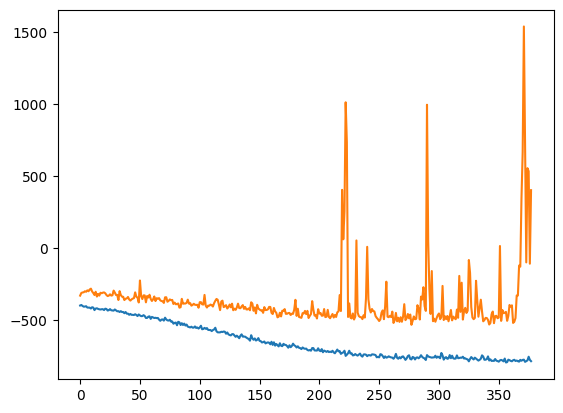

alpha 0.2 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-08-22 07:15:00.054147


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1
predict diverge [-25.43255136 279.57858675  21.17047775  37.4725657 ] [-2.17107201e-01  2.89264214e+02  1.63367071e+00 -4.81838302e+00] [138.03265   22.220108 300.45007   46.24776 ] [ 69.01633   11.110054 150.22504   23.12388 ] sim_timestep 176

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15
predict diverge [-23.05878931 -25.90396202 -13.28345192 -24.72873428] [-0.9712776  -5.71093057 -0.79972366 -1.45776743] [138.03265   22.220108 300.45007   46.24776 ] [ 69.01633   11.110054 150.22504   23.12388 ] sim_timestep 190

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27
predict diverge [  3.64088769 -27.01338555  15.42802475  22.93464021] [  0.16464514 -28.0475081    1.4554871  -10.40040152] [138.03265   22.220108 300.45007   46.24776 ] [ 69.01633   11.110054 150.22504   23.12388 ] sim_timestep 194

 28

 29

 30

 31

 32

 33

 34
predict diverge [-28.00994155 -28.01332818  13.3528022   33.35116455] [ -0.41578743 -14.05383606   1.10835303   1.89636515] [138

In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.89816  validloss 2.43069±0.00000  bestvalidloss 2.43069  last_update 0
train: iter 1  trainloss 0.65902  validloss 1.07649±0.00000  bestvalidloss 1.07649  last_update 0
train: iter 2  trainloss 0.57618  validloss 0.99450±0.00000  bestvalidloss 0.99450  last_update 0
train: iter 3  trainloss 0.52900  validloss 0.88329±0.00000  bestvalidloss 0.88329  last_update 0
train: iter 4  trainloss 0.50990  validloss 0.86853±0.00000  bestvalidloss 0.86853  last_update 0
train: iter 5  trainloss 0.49539  validloss 0.82748±0.00000  bestvalidloss 0.82748  last_update 0
train: iter 6  trainloss 0.47840  validloss 0.82275±0.00000  bestvalidloss 0.82275  last_update 0
train: iter 7  trainloss 0.47201  validloss 0.74195±0.00000  bestvalidloss 0.74195  last_update 0
train: iter 8  trainloss 0.46507  validloss 0.78487±0.00000  bestvalidloss 0.74195  last_update 1
train: iter 9  trainloss 0.45924  validloss 0.78279±0.00000  bestvalidloss 0.74195  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.36274  validloss 0.69149±0.00000  bestvalidloss 0.64146  last_update 9
train: iter 84  trainloss 0.36255  validloss 0.68691±0.00000  bestvalidloss 0.64146  last_update 10
train: iter 85  trainloss 0.36138  validloss 0.73726±0.00000  bestvalidloss 0.64146  last_update 11
train: iter 86  trainloss 0.35866  validloss 0.73790±0.00000  bestvalidloss 0.64146  last_update 12
train: iter 87  trainloss 0.35959  validloss 0.80040±0.00000  bestvalidloss 0.64146  last_update 13
train: iter 88  trainloss 0.35783  validloss 0.68742±0.00000  bestvalidloss 0.64146  last_update 14
train: iter 89  trainloss 0.35758  validloss 0.67343±0.00000  bestvalidloss 0.64146  last_update 15
train: iter 90  trainloss 0.35621  validloss 0.79208±0.00000  bestvalidloss 0.64146  last_update 16
train: iter 91  trainloss 0.35731  validloss 0.70389±0.00000  bestvalidloss 0.64146  last_update 17
train: iter 92  trainloss 0.35543  validloss 0.71502±0.00000  bestvalidloss 0.64146  last_update 18
t

train: iter 165  trainloss 0.33131  validloss 0.79394±0.00000  bestvalidloss 0.64146  last_update 91
train: iter 166  trainloss 0.32935  validloss 0.78874±0.00000  bestvalidloss 0.64146  last_update 92
train: iter 167  trainloss 0.32976  validloss 0.74217±0.00000  bestvalidloss 0.64146  last_update 93
train: iter 168  trainloss 0.32612  validloss 0.77708±0.00000  bestvalidloss 0.64146  last_update 94
train: iter 169  trainloss 0.32689  validloss 0.73820±0.00000  bestvalidloss 0.64146  last_update 95
train: iter 170  trainloss 0.32574  validloss 0.70244±0.00000  bestvalidloss 0.64146  last_update 96
train: iter 171  trainloss 0.32804  validloss 0.71661±0.00000  bestvalidloss 0.64146  last_update 97
train: iter 172  trainloss 0.32516  validloss 0.74683±0.00000  bestvalidloss 0.64146  last_update 98
train: iter 173  trainloss 0.32487  validloss 0.76597±0.00000  bestvalidloss 0.64146  last_update 99
train: iter 174  trainloss 0.32069  validloss 0.70696±0.00000  bestvalidloss 0.64146  last_

train_loss:  -4.349813247317076
valid_loss:  6.1317718538045884
weight_alpha 1.0 h_min_tilde -11.461294 ell_tilde -2.2534962270927434 kappa_tilde 0.00016477530112481818
train_loss:  -3.0800124514341354
valid_loss:  5.2504516613006595
weight_alpha 0.2 h_min_tilde -11.461294 ell_tilde -1.4139196288871767 kappa_tilde 0.00015774067984520565


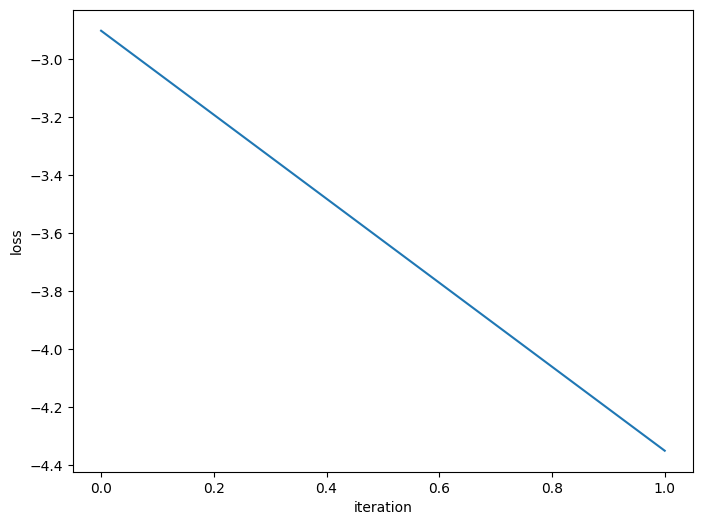

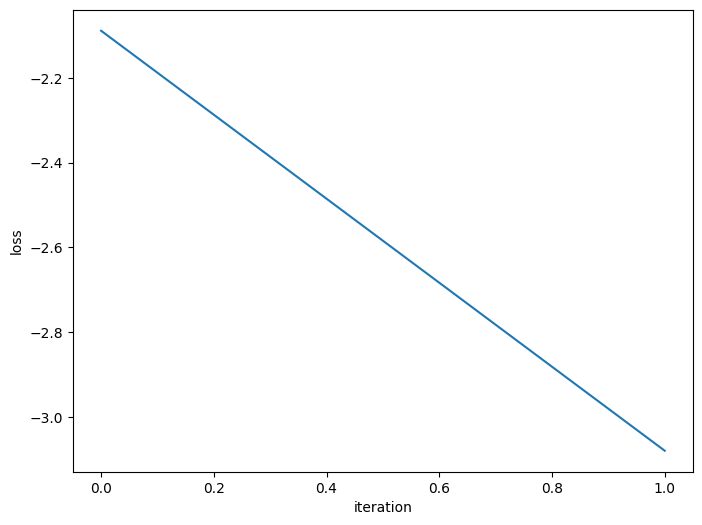

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -599.74366  validloss 1024.03888±0.00000  bestvalidloss 1024.03888  last_update 0
train: iter 1  trainloss -601.41875  validloss 770.43409±0.00000  bestvalidloss 770.43409  last_update 0
train: iter 2  trainloss -596.04366  validloss 307.96965±0.00000  bestvalidloss 307.96965  last_update 0
train: iter 3  trainloss -529.01103  validloss 81.10347±0.00000  bestvalidloss 81.10347  last_update 0
train: iter 4  trainloss -569.76251  validloss -277.66206±0.00000  bestvalidloss -277.66206  last_update 0
train: iter 5  trainloss -604.06094  validloss -244.44802±0.00000  bestvalidloss -277.66206  last_update 1
train: iter 6  trainloss -619.33070  validloss -243.43068±0.00000  bestvalidloss -277.66206  last_update 2
train: iter 7  trainloss -599.01235  validloss -322.47247±0.00000  bestvalidloss -322.47247  last_update 0
train: iter 8  trainloss -585.47998  validloss -296.20113±0.00000  bestvalidloss -322.47247  last_update 1


train: iter 76  trainloss -583.81433  validloss -428.27607±0.00000  bestvalidloss -479.06568  last_update 2
train: iter 77  trainloss -620.59997  validloss -166.63898±0.00000  bestvalidloss -479.06568  last_update 3
train: iter 78  trainloss -625.68778  validloss -213.25996±0.00000  bestvalidloss -479.06568  last_update 4
train: iter 79  trainloss -650.05249  validloss -75.16460±0.00000  bestvalidloss -479.06568  last_update 5
train: iter 80  trainloss -645.42257  validloss -122.66777±0.00000  bestvalidloss -479.06568  last_update 6
train: iter 81  trainloss -602.89191  validloss -313.89317±0.00000  bestvalidloss -479.06568  last_update 7
train: iter 82  trainloss -569.37155  validloss 818.57281±0.00000  bestvalidloss -479.06568  last_update 8
train: iter 83  trainloss -636.90473  validloss -103.87385±0.00000  bestvalidloss -479.06568  last_update 9
train: iter 84  trainloss -628.03771  validloss 161.17883±0.00000  bestvalidloss -479.06568  last_update 10
train: iter 85  trainloss -648

train: iter 152  trainloss -644.23908  validloss -468.74204±0.00000  bestvalidloss -496.29886  last_update 18
train: iter 153  trainloss -662.11860  validloss -485.55749±0.00000  bestvalidloss -496.29886  last_update 19
train: iter 154  trainloss -653.99442  validloss -484.23604±0.00000  bestvalidloss -496.29886  last_update 20
train: iter 155  trainloss -645.32359  validloss -452.21121±0.00000  bestvalidloss -496.29886  last_update 21
train: iter 156  trainloss -632.54791  validloss -362.74548±0.00000  bestvalidloss -496.29886  last_update 22
train: iter 157  trainloss -624.54503  validloss -369.23498±0.00000  bestvalidloss -496.29886  last_update 23
train: iter 158  trainloss -655.53719  validloss -462.87214±0.00000  bestvalidloss -496.29886  last_update 24
train: iter 159  trainloss -640.93749  validloss -479.98689±0.00000  bestvalidloss -496.29886  last_update 25
train: iter 160  trainloss -649.79693  validloss -304.20733±0.00000  bestvalidloss -496.29886  last_update 26
train: ite

train: iter 227  trainloss -662.10093  validloss -488.23334±0.00000  bestvalidloss -514.19619  last_update 47
train: iter 228  trainloss -621.21539  validloss -479.11803±0.00000  bestvalidloss -514.19619  last_update 48
train: iter 229  trainloss -636.96238  validloss -388.09005±0.00000  bestvalidloss -514.19619  last_update 49
train: iter 230  trainloss -678.63781  validloss -437.00071±0.00000  bestvalidloss -514.19619  last_update 50
train: iter 231  trainloss -675.37236  validloss -380.23285±0.00000  bestvalidloss -514.19619  last_update 51
train: iter 232  trainloss -397.26890  validloss -383.15031±0.00000  bestvalidloss -514.19619  last_update 52
train: iter 233  trainloss -386.11741  validloss -107.37905±0.00000  bestvalidloss -514.19619  last_update 53
train: iter 234  trainloss -522.18152  validloss -304.52067±0.00000  bestvalidloss -514.19619  last_update 54
train: iter 235  trainloss -563.13509  validloss -323.41895±0.00000  bestvalidloss -514.19619  last_update 55
train: ite

train: iter 302  trainloss -684.93642  validloss -475.77761±0.00000  bestvalidloss -538.02172  last_update 1
train: iter 303  trainloss -678.87035  validloss -505.94409±0.00000  bestvalidloss -538.02172  last_update 2
train: iter 304  trainloss -688.66245  validloss -464.66148±0.00000  bestvalidloss -538.02172  last_update 3
train: iter 305  trainloss -690.60979  validloss -519.01064±0.00000  bestvalidloss -538.02172  last_update 4
train: iter 306  trainloss -691.18305  validloss -517.65576±0.00000  bestvalidloss -538.02172  last_update 5
train: iter 307  trainloss -680.39931  validloss -512.46260±0.00000  bestvalidloss -538.02172  last_update 6
train: iter 308  trainloss -685.08608  validloss -474.98285±0.00000  bestvalidloss -538.02172  last_update 7
train: iter 309  trainloss -682.32117  validloss -510.05454±0.00000  bestvalidloss -538.02172  last_update 8
train: iter 310  trainloss -585.00541  validloss -482.31217±0.00000  bestvalidloss -538.02172  last_update 9
train: iter 311  tr

train: iter 377  trainloss -682.60268  validloss -510.65476±0.00000  bestvalidloss -548.07498  last_update 26
train: iter 378  trainloss -705.83214  validloss -493.56219±0.00000  bestvalidloss -548.07498  last_update 27
train: iter 379  trainloss -703.04244  validloss -536.11382±0.00000  bestvalidloss -548.07498  last_update 28
train: iter 380  trainloss -704.95220  validloss -535.57158±0.00000  bestvalidloss -548.07498  last_update 29
train: iter 381  trainloss -670.01443  validloss -528.12746±0.00000  bestvalidloss -548.07498  last_update 30
train: iter 382  trainloss -659.04972  validloss -321.40055±0.00000  bestvalidloss -548.07498  last_update 31
train: iter 383  trainloss -698.75442  validloss -501.80410±0.00000  bestvalidloss -548.07498  last_update 32
train: iter 384  trainloss -692.36433  validloss -514.70208±0.00000  bestvalidloss -548.07498  last_update 33
train: iter 385  trainloss -711.35765  validloss -493.64951±0.00000  bestvalidloss -548.07498  last_update 34
train: ite

train: iter 452  trainloss -659.56614  validloss -507.59801±0.00000  bestvalidloss -548.94887  last_update 35
train: iter 453  trainloss -640.30376  validloss -249.09468±0.00000  bestvalidloss -548.94887  last_update 36
train: iter 454  trainloss -715.64002  validloss -510.88835±0.00000  bestvalidloss -548.94887  last_update 37
train: iter 455  trainloss -715.01716  validloss -548.42863±0.00000  bestvalidloss -548.94887  last_update 38
train: iter 456  trainloss -718.73334  validloss -530.86685±0.00000  bestvalidloss -548.94887  last_update 39
train: iter 457  trainloss -705.34916  validloss -490.12188±0.00000  bestvalidloss -548.94887  last_update 40
train: iter 458  trainloss -712.62448  validloss -540.24803±0.00000  bestvalidloss -548.94887  last_update 41
train: iter 459  trainloss -689.56760  validloss -498.97860±0.00000  bestvalidloss -548.94887  last_update 42
train: iter 460  trainloss -710.19253  validloss -477.16134±0.00000  bestvalidloss -548.94887  last_update 43
train: ite

train: iter 527  trainloss -693.43509  validloss -496.21832±0.00000  bestvalidloss -552.72619  last_update 1
train: iter 528  trainloss -671.65169  validloss -484.62166±0.00000  bestvalidloss -552.72619  last_update 2
train: iter 529  trainloss -722.06513  validloss -517.01472±0.00000  bestvalidloss -552.72619  last_update 3
train: iter 530  trainloss -725.15995  validloss -529.38035±0.00000  bestvalidloss -552.72619  last_update 4
train: iter 531  trainloss -736.97042  validloss -549.97869±0.00000  bestvalidloss -552.72619  last_update 5
train: iter 532  trainloss -714.15192  validloss -543.62389±0.00000  bestvalidloss -552.72619  last_update 6
train: iter 533  trainloss -725.28242  validloss -538.51386±0.00000  bestvalidloss -552.72619  last_update 7
train: iter 534  trainloss -734.63482  validloss -500.76336±0.00000  bestvalidloss -552.72619  last_update 8
train: iter 535  trainloss -619.72957  validloss -569.52574±0.00000  bestvalidloss -569.52574  last_update 0
train: iter 536  tr

train: iter 602  trainloss -721.78578  validloss -534.48486±0.00000  bestvalidloss -572.01033  last_update 26
train: iter 603  trainloss -744.02888  validloss -522.19428±0.00000  bestvalidloss -572.01033  last_update 27
train: iter 604  trainloss -737.52094  validloss -545.58897±0.00000  bestvalidloss -572.01033  last_update 28
train: iter 605  trainloss -706.73411  validloss -494.24659±0.00000  bestvalidloss -572.01033  last_update 29
train: iter 606  trainloss -750.93236  validloss -541.07323±0.00000  bestvalidloss -572.01033  last_update 30
train: iter 607  trainloss -713.10582  validloss -540.96210±0.00000  bestvalidloss -572.01033  last_update 31
train: iter 608  trainloss -724.84291  validloss -417.65490±0.00000  bestvalidloss -572.01033  last_update 32
train: iter 609  trainloss -708.69347  validloss -506.96117±0.00000  bestvalidloss -572.01033  last_update 33
train: iter 610  trainloss -746.48013  validloss -527.50541±0.00000  bestvalidloss -572.01033  last_update 34
train: ite

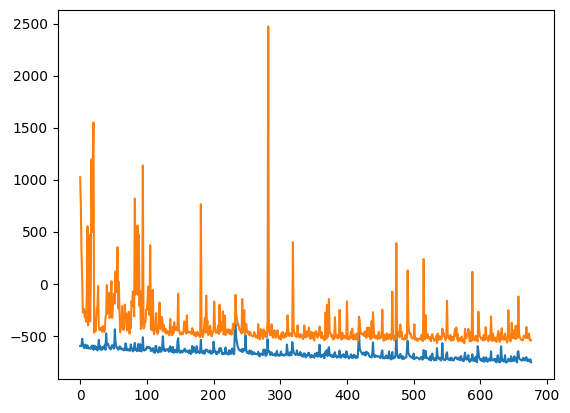

alpha 0.2 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-08-22 07:42:49.707903


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35
predict diverge [-5.60439632 22.6252651  27.95542097 29.72493674] [0.90313332 4.00331591 1.36675387 0.73241764] [138.03265   22.220108 300.45007   46.24776 ] [ 69.01633   11.110054 150.22504   23.12388 ] sim_timestep 132

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65
predict diverge [18.24778906 22.67823512 81.84785788 19.13246193] [1.06107954 0.72124034 0.92548653 2.11457548] [138.03265   22.220108 300.45007   46.24776 ] [ 69.01633   11.110054 150.22504   23.12388 ] sim_timestep 176

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.49847  validloss 0.86469±0.00000  bestvalidloss 0.86469  last_update 0
train: iter 1  trainloss 0.44278  validloss 0.45778±0.00000  bestvalidloss 0.45778  last_update 0
train: iter 2  trainloss 0.42973  validloss 0.45569±0.00000  bestvalidloss 0.45569  last_update 0
train: iter 3  trainloss 0.43152  validloss 0.47960±0.00000  bestvalidloss 0.45569  last_update 1
train: iter 4  trainloss 0.42393  validloss 0.43147±0.00000  bestvalidloss 0.43147  last_update 0
train: iter 5  trainloss 0.41607  validloss 0.46326±0.00000  bestvalidloss 0.43147  last_update 1
train: iter 6  trainloss 0.41007  validloss 0.44996±0.00000  bestvalidloss 0.43147  last_update 2
train: iter 7  trainloss 0.40817  validloss 0.44435±0.00000  bestvalidloss 0.43147  last_update 3
train: iter 8  trainloss 0.41606  validloss 0.44771±0.00000  bestvalidloss 0.43147  last_update 4
train: iter 9  trainloss 0.40706  validloss 0.46433±0.00000  bestvalidloss 0.43147  last_update 5
train: iter 10  trai

train: iter 83  trainloss 0.35265  validloss 0.48825±0.00000  bestvalidloss 0.42207  last_update 52
train: iter 84  trainloss 0.35469  validloss 0.43396±0.00000  bestvalidloss 0.42207  last_update 53
train: iter 85  trainloss 0.35642  validloss 0.47169±0.00000  bestvalidloss 0.42207  last_update 54
train: iter 86  trainloss 0.35477  validloss 0.44492±0.00000  bestvalidloss 0.42207  last_update 55
train: iter 87  trainloss 0.35270  validloss 0.45309±0.00000  bestvalidloss 0.42207  last_update 56
train: iter 88  trainloss 0.36028  validloss 0.45905±0.00000  bestvalidloss 0.42207  last_update 57
train: iter 89  trainloss 0.34863  validloss 0.46570±0.00000  bestvalidloss 0.42207  last_update 58
train: iter 90  trainloss 0.35976  validloss 0.51564±0.00000  bestvalidloss 0.42207  last_update 59
train: iter 91  trainloss 0.35474  validloss 0.44739±0.00000  bestvalidloss 0.42207  last_update 60
train: iter 92  trainloss 0.35651  validloss 0.47618±0.00000  bestvalidloss 0.42207  last_update 61


train_loss:  -5.656247276234625
valid_loss:  -4.798722367060185
weight_alpha 1.0 h_min_tilde -11.658644 ell_tilde -5.484742294399736 kappa_tilde 0.0002012288098866381
train_loss:  -2.866286412310601
valid_loss:  -2.1631029580593113
weight_alpha 0.2 h_min_tilde -11.658644 ell_tilde -2.725649721460343 kappa_tilde 0.0001672905785722253


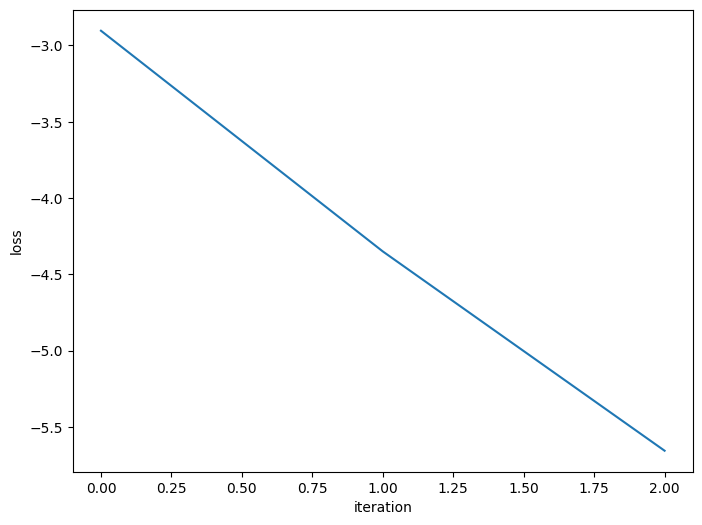

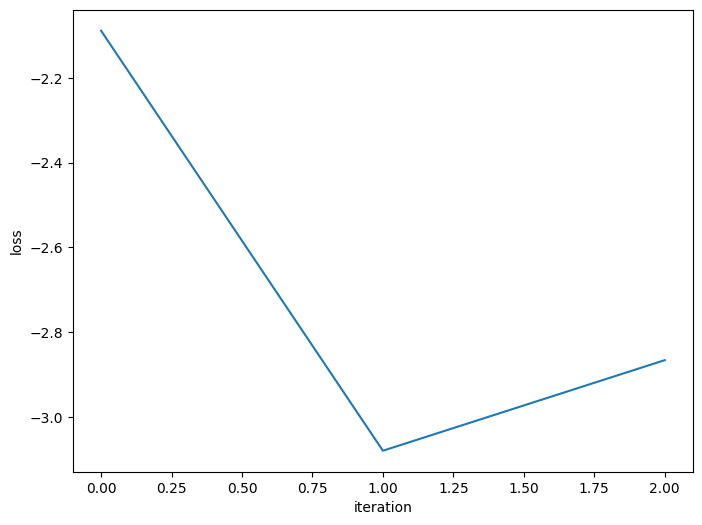

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -555.02573  validloss -434.64449±0.00000  bestvalidloss -434.64449  last_update 0
train: iter 1  trainloss -572.17833  validloss -400.99869±0.00000  bestvalidloss -434.64449  last_update 1
train: iter 2  trainloss -575.74716  validloss -462.99353±0.00000  bestvalidloss -462.99353  last_update 0
train: iter 3  trainloss -579.60934  validloss -460.29083±0.00000  bestvalidloss -462.99353  last_update 1
train: iter 4  trainloss -572.38608  validloss -469.02823±0.00000  bestvalidloss -469.02823  last_update 0
train: iter 5  trainloss -564.70340  validloss -425.26188±0.00000  bestvalidloss -469.02823  last_update 1
train: iter 6  trainloss -577.92392  validloss -428.79224±0.00000  bestvalidloss -469.02823  last_update 2
train: iter 7  trainloss -562.41086  validloss -444.36797±0.00000  bestvalidloss -469.02823  last_update 3
train: iter 8  trainloss -583.55463  validloss -391.19821±0.00000  bestvalidloss -469.02823  last_u

train: iter 75  trainloss -565.49861  validloss -406.01752±0.00000  bestvalidloss -469.02823  last_update 71
train: iter 76  trainloss -560.80378  validloss -412.75538±0.00000  bestvalidloss -469.02823  last_update 72
train: iter 77  trainloss -574.29343  validloss -402.95571±0.00000  bestvalidloss -469.02823  last_update 73
train: iter 78  trainloss -581.52291  validloss -442.59717±0.00000  bestvalidloss -469.02823  last_update 74
train: iter 79  trainloss -584.85107  validloss -435.77423±0.00000  bestvalidloss -469.02823  last_update 75
train: iter 80  trainloss -578.85735  validloss -452.72947±0.00000  bestvalidloss -469.02823  last_update 76
train: iter 81  trainloss -589.40336  validloss -464.67218±0.00000  bestvalidloss -469.02823  last_update 77
train: iter 82  trainloss -565.80296  validloss -466.36643±0.00000  bestvalidloss -469.02823  last_update 78
train: iter 83  trainloss -588.05591  validloss -436.98724±0.00000  bestvalidloss -469.02823  last_update 79
train: iter 84  tra

train: iter 150  trainloss -581.49769  validloss -476.53817±0.00000  bestvalidloss -481.04034  last_update 2
train: iter 151  trainloss -585.06436  validloss -424.53739±0.00000  bestvalidloss -481.04034  last_update 3
train: iter 152  trainloss -593.71778  validloss -459.32299±0.00000  bestvalidloss -481.04034  last_update 4
train: iter 153  trainloss -585.34415  validloss -403.23319±0.00000  bestvalidloss -481.04034  last_update 5
train: iter 154  trainloss -580.01212  validloss -449.82391±0.00000  bestvalidloss -481.04034  last_update 6
train: iter 155  trainloss -496.99088  validloss -6.47163±0.00000  bestvalidloss -481.04034  last_update 7
train: iter 156  trainloss -592.35636  validloss -431.93309±0.00000  bestvalidloss -481.04034  last_update 8
train: iter 157  trainloss -593.74003  validloss -455.66443±0.00000  bestvalidloss -481.04034  last_update 9
train: iter 158  trainloss -588.41273  validloss -442.95610±0.00000  bestvalidloss -481.04034  last_update 10
train: iter 159  tra

train: iter 225  trainloss -596.87323  validloss -484.34403±0.00000  bestvalidloss -484.34403  last_update 0
train: iter 226  trainloss -600.33076  validloss -475.09618±0.00000  bestvalidloss -484.34403  last_update 1
train: iter 227  trainloss -606.07315  validloss -479.94998±0.00000  bestvalidloss -484.34403  last_update 2
train: iter 228  trainloss -604.51694  validloss -478.62506±0.00000  bestvalidloss -484.34403  last_update 3
train: iter 229  trainloss -590.28226  validloss -472.73966±0.00000  bestvalidloss -484.34403  last_update 4
train: iter 230  trainloss -551.33124  validloss 269.77435±0.00000  bestvalidloss -484.34403  last_update 5
train: iter 231  trainloss -604.64148  validloss -456.97749±0.00000  bestvalidloss -484.34403  last_update 6
train: iter 232  trainloss -602.65600  validloss -464.75237±0.00000  bestvalidloss -484.34403  last_update 7
train: iter 233  trainloss -604.97385  validloss -465.97584±0.00000  bestvalidloss -484.34403  last_update 8
train: iter 234  tra

train: iter 300  trainloss -605.61294  validloss -449.73898±0.00000  bestvalidloss -494.71040  last_update 46
train: iter 301  trainloss -607.34283  validloss -454.81751±0.00000  bestvalidloss -494.71040  last_update 47
train: iter 302  trainloss -605.15126  validloss -478.68664±0.00000  bestvalidloss -494.71040  last_update 48
train: iter 303  trainloss -585.79581  validloss -391.62537±0.00000  bestvalidloss -494.71040  last_update 49
train: iter 304  trainloss -607.29420  validloss -469.95196±0.00000  bestvalidloss -494.71040  last_update 50
train: iter 305  trainloss -603.13564  validloss -464.06233±0.00000  bestvalidloss -494.71040  last_update 51
train: iter 306  trainloss -589.37684  validloss -477.53288±0.00000  bestvalidloss -494.71040  last_update 52
train: iter 307  trainloss -599.26869  validloss -377.63155±0.00000  bestvalidloss -494.71040  last_update 53
train: iter 308  trainloss -610.72496  validloss -459.06292±0.00000  bestvalidloss -494.71040  last_update 54
train: ite

train: iter 375  trainloss -584.10586  validloss -470.70452±0.00000  bestvalidloss -503.90360  last_update 29
train: iter 376  trainloss -601.22561  validloss -441.72538±0.00000  bestvalidloss -503.90360  last_update 30
train: iter 377  trainloss -606.11294  validloss -457.27603±0.00000  bestvalidloss -503.90360  last_update 31
train: iter 378  trainloss -586.02378  validloss -461.71842±0.00000  bestvalidloss -503.90360  last_update 32
train: iter 379  trainloss -596.74583  validloss -456.44235±0.00000  bestvalidloss -503.90360  last_update 33
train: iter 380  trainloss -607.20534  validloss -444.41636±0.00000  bestvalidloss -503.90360  last_update 34
train: iter 381  trainloss -607.24793  validloss -461.33358±0.00000  bestvalidloss -503.90360  last_update 35
train: iter 382  trainloss -613.63224  validloss -472.82956±0.00000  bestvalidloss -503.90360  last_update 36
train: iter 383  trainloss -608.70727  validloss -468.73309±0.00000  bestvalidloss -503.90360  last_update 37
train: ite

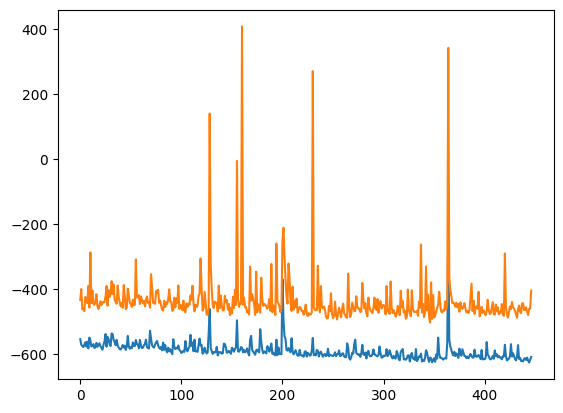

alpha 0.2 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-08-22 08:46:45.589043


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.41144  validloss 0.48496±0.00000  bestvalidloss 0.48496  last_update 0
train: iter 1  trainloss 0.40636  validloss 0.45071±0.00000  bestvalidloss 0.45071  last_update 0
train: iter 2  trainloss 0.39230  validloss 0.43703±0.00000  bestvalidloss 0.43703  last_update 0
train: iter 3  trainloss 0.38922  validloss 0.43162±0.00000  bestvalidloss 0.43162  last_update 0
train: iter 4  trainloss 0.39180  validloss 0.42897±0.00000  bestvalidloss 0.42897  last_update 0
train: iter 5  trainloss 0.38810  validloss 0.43686±0.00000  bestvalidloss 0.42897  last_update 1
train: iter 6  trainloss 0.38894  validloss 0.42302±0.00000  bestvalidloss 0.42302  last_update 0
train: iter 7  trainloss 0.38863  validloss 0.43069±0.00000  bestvalidloss 0.42302  last_update 1
train: iter 8  trainloss 0.38125  validloss 0.44913±0.00000  bestvalidloss 0.42302  last_update 2
train: iter 9  trainloss 0.38262  validloss 0.42418±0.00000  bestvalidloss 0.42302  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.35494  validloss 0.45835±0.00000  bestvalidloss 0.40301  last_update 29
train: iter 84  trainloss 0.35509  validloss 0.40917±0.00000  bestvalidloss 0.40301  last_update 30
train: iter 85  trainloss 0.34846  validloss 0.44129±0.00000  bestvalidloss 0.40301  last_update 31
train: iter 86  trainloss 0.35637  validloss 0.45946±0.00000  bestvalidloss 0.40301  last_update 32
train: iter 87  trainloss 0.35485  validloss 0.42368±0.00000  bestvalidloss 0.40301  last_update 33
train: iter 88  trainloss 0.35106  validloss 0.40530±0.00000  bestvalidloss 0.40301  last_update 34
train: iter 89  trainloss 0.35128  validloss 0.42090±0.00000  bestvalidloss 0.40301  last_update 35
train: iter 90  trainloss 0.35838  validloss 0.41781±0.00000  bestvalidloss 0.40301  last_update 36
train: iter 91  trainloss 0.35441  validloss 0.41733±0.00000  bestvalidloss 0.40301  last_update 37
train: iter 92  trainloss 0.35572  validloss 0.43718±0.00000  bestvalidloss 0.40301  last_update 38


train_loss:  -6.395955601590872
valid_loss:  -5.744308396911621
weight_alpha 1.0 h_min_tilde -11.717159 ell_tilde -6.265626160655022 kappa_tilde 0.00021414635037016118
train_loss:  -3.0413489737391477
valid_loss:  -1.880714389657974
weight_alpha 0.2 h_min_tilde -11.717159 ell_tilde -2.809222056922913 kappa_tilde 0.0001675256958995607


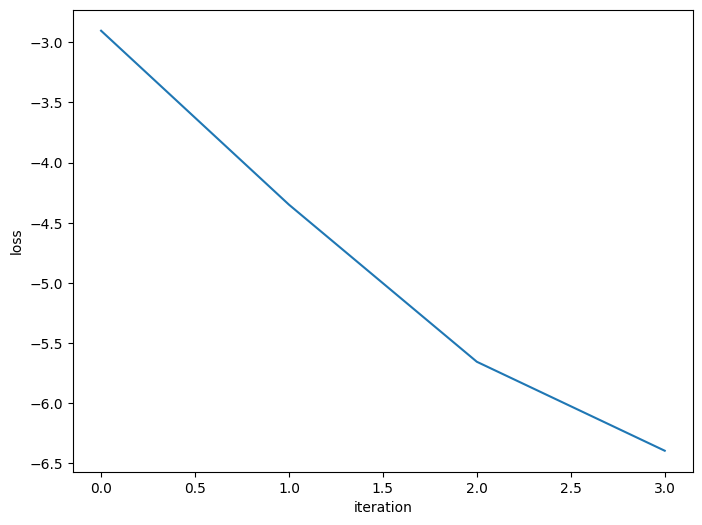

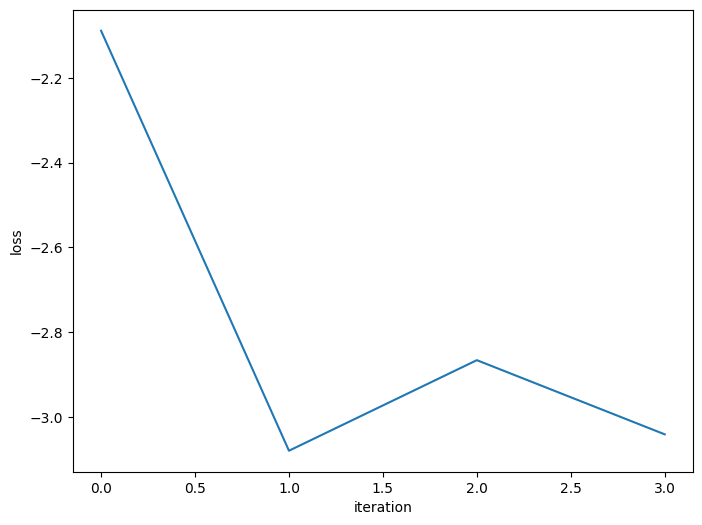

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -646.21500  validloss -382.30340±0.00000  bestvalidloss -382.30340  last_update 0
train: iter 1  trainloss -647.29961  validloss -482.30213±0.00000  bestvalidloss -482.30213  last_update 0
train: iter 2  trainloss -658.61078  validloss -470.11637±0.00000  bestvalidloss -482.30213  last_update 1
train: iter 3  trainloss -659.24186  validloss -520.82111±0.00000  bestvalidloss -520.82111  last_update 0
train: iter 4  trainloss -643.45652  validloss -494.70072±0.00000  bestvalidloss -520.82111  last_update 1
train: iter 5  trainloss -644.10993  validloss -419.61265±0.00000  bestvalidloss -520.82111  last_update 2
train: iter 6  trainloss -663.07079  validloss -439.90827±0.00000  bestvalidloss -520.82111  last_update 3
train: iter 7  trainloss -637.35423  validloss -491.74632±0.00000  bestvalidloss -520.82111  last_update 4
train: iter 8  trainloss -631.91228  validloss -412.61838±0.00000  bestvalidloss -520.82111  last_u

train: iter 76  trainloss -657.96966  validloss -505.74464±0.00000  bestvalidloss -529.19887  last_update 47
train: iter 77  trainloss -660.05309  validloss -515.64246±0.00000  bestvalidloss -529.19887  last_update 48
train: iter 78  trainloss -662.81398  validloss -496.23439±0.00000  bestvalidloss -529.19887  last_update 49
train: iter 79  trainloss -671.50097  validloss -537.42994±0.00000  bestvalidloss -537.42994  last_update 0
train: iter 80  trainloss -659.01068  validloss -472.60615±0.00000  bestvalidloss -537.42994  last_update 1
train: iter 81  trainloss -655.45524  validloss -432.06915±0.00000  bestvalidloss -537.42994  last_update 2
train: iter 82  trainloss -661.91412  validloss -468.69718±0.00000  bestvalidloss -537.42994  last_update 3
train: iter 83  trainloss -667.70679  validloss -510.34758±0.00000  bestvalidloss -537.42994  last_update 4
train: iter 84  trainloss -668.76623  validloss -512.75111±0.00000  bestvalidloss -537.42994  last_update 5
train: iter 85  trainloss

train: iter 151  trainloss -668.67245  validloss -526.46940±0.00000  bestvalidloss -537.42994  last_update 72
train: iter 152  trainloss -667.24617  validloss -520.30971±0.00000  bestvalidloss -537.42994  last_update 73
train: iter 153  trainloss -657.83621  validloss -479.01151±0.00000  bestvalidloss -537.42994  last_update 74
train: iter 154  trainloss -669.28374  validloss -500.02438±0.00000  bestvalidloss -537.42994  last_update 75
train: iter 155  trainloss -673.13171  validloss -525.53519±0.00000  bestvalidloss -537.42994  last_update 76
train: iter 156  trainloss -670.17072  validloss -528.09931±0.00000  bestvalidloss -537.42994  last_update 77
train: iter 157  trainloss -659.30894  validloss -534.40192±0.00000  bestvalidloss -537.42994  last_update 78
train: iter 158  trainloss -671.66639  validloss -503.46559±0.00000  bestvalidloss -537.42994  last_update 79
train: iter 159  trainloss -675.54240  validloss -531.21624±0.00000  bestvalidloss -537.42994  last_update 80
train: ite

train: iter 226  trainloss -662.34415  validloss -492.30757±0.00000  bestvalidloss -545.17612  last_update 66
train: iter 227  trainloss -671.35317  validloss -488.34976±0.00000  bestvalidloss -545.17612  last_update 67
train: iter 228  trainloss -675.32410  validloss -524.71947±0.00000  bestvalidloss -545.17612  last_update 68
train: iter 229  trainloss -660.68243  validloss -508.77775±0.00000  bestvalidloss -545.17612  last_update 69
train: iter 230  trainloss -668.25932  validloss -430.58019±0.00000  bestvalidloss -545.17612  last_update 70
train: iter 231  trainloss -676.84348  validloss -512.42299±0.00000  bestvalidloss -545.17612  last_update 71
train: iter 232  trainloss -675.51790  validloss -509.61009±0.00000  bestvalidloss -545.17612  last_update 72
train: iter 233  trainloss -672.29054  validloss -525.65161±0.00000  bestvalidloss -545.17612  last_update 73
train: iter 234  trainloss -587.86392  validloss -514.83860±0.00000  bestvalidloss -545.17612  last_update 74
train: ite

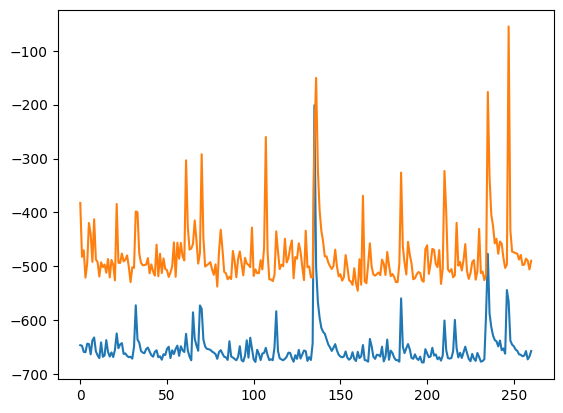

alpha 0.2 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-08-22 09:13:33.456194


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34
predict diverge [ 49.90439064  24.46750327 -91.49772513 -27.69529593] [1.36129454 2.5943644  6.63993926 3.73055379] [138.03265   22.220108 300.45007   46.24776 ] [ 69.01633   11.110054 150.22504   23.12388 ] sim_timestep 125

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44
predict diverge [ 21.65332635 -45.04122698  48.47192769  32.17397387] [  0.81480791 -62.89827682   1.26819325   2.87371463] [138.03265   22.220108 300.45007   46.24776 ] [ 69.01633   11.110054 150.22504   23.12388 ] sim_timestep 197

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54
predict diverge [ 21.56822567 -24.13130045  47.94725762  20.70727051] [-0.8711035  -2.188358    0.5146228  -0.35745326] [138.03265   22.220108 300.45007   46.24776 ] [ 69.01633   11.110054 150.22504   23.12388 ] sim_timestep 146

 55

 56

 57

 58

 59

 60

 61

 62

 63
pre

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.47443  validloss 0.46715±0.00000  bestvalidloss 0.46715  last_update 0
train: iter 1  trainloss 0.43349  validloss 0.40286±0.00000  bestvalidloss 0.40286  last_update 0
train: iter 2  trainloss 0.42311  validloss 0.39925±0.00000  bestvalidloss 0.39925  last_update 0
train: iter 3  trainloss 0.42111  validloss 0.39351±0.00000  bestvalidloss 0.39351  last_update 0
train: iter 4  trainloss 0.40690  validloss 0.39787±0.00000  bestvalidloss 0.39351  last_update 1
train: iter 5  trainloss 0.40676  validloss 0.39083±0.00000  bestvalidloss 0.39083  last_update 0
train: iter 6  trainloss 0.39823  validloss 0.40473±0.00000  bestvalidloss 0.39083  last_update 1
train: iter 7  trainloss 0.39738  validloss 0.40073±0.00000  bestvalidloss 0.39083  last_update 2
train: iter 8  trainloss 0.39751  validloss 0.42300±0.00000  bestvalidloss 0.39083  last_update 3
train: iter 9  trainloss 0.39701  validloss 0.41233±0.00000  bestvalidloss 0.39083  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.35528  validloss 0.42162±0.00000  bestvalidloss 0.38243  last_update 15
train: iter 84  trainloss 0.35700  validloss 0.40472±0.00000  bestvalidloss 0.38243  last_update 16
train: iter 85  trainloss 0.35560  validloss 0.41077±0.00000  bestvalidloss 0.38243  last_update 17
train: iter 86  trainloss 0.35613  validloss 0.37069±0.00000  bestvalidloss 0.37069  last_update 0
train: iter 87  trainloss 0.35362  validloss 0.41533±0.00000  bestvalidloss 0.37069  last_update 1
train: iter 88  trainloss 0.35403  validloss 0.43145±0.00000  bestvalidloss 0.37069  last_update 2
train: iter 89  trainloss 0.35697  validloss 0.39533±0.00000  bestvalidloss 0.37069  last_update 3
train: iter 90  trainloss 0.35160  validloss 0.40673±0.00000  bestvalidloss 0.37069  last_update 4
train: iter 91  trainloss 0.35932  validloss 0.41332±0.00000  bestvalidloss 0.37069  last_update 5
train: iter 92  trainloss 0.35213  validloss 0.39258±0.00000  bestvalidloss 0.37069  last_update 6
train: 

train: iter 166  trainloss 0.33962  validloss 0.41413±0.00000  bestvalidloss 0.37069  last_update 80
train: iter 167  trainloss 0.34088  validloss 0.38578±0.00000  bestvalidloss 0.37069  last_update 81
train: iter 168  trainloss 0.33973  validloss 0.40325±0.00000  bestvalidloss 0.37069  last_update 82
train: iter 169  trainloss 0.33846  validloss 0.38947±0.00000  bestvalidloss 0.37069  last_update 83
train: iter 170  trainloss 0.33727  validloss 0.43285±0.00000  bestvalidloss 0.37069  last_update 84
train: iter 171  trainloss 0.34112  validloss 0.38134±0.00000  bestvalidloss 0.37069  last_update 85
train: iter 172  trainloss 0.33629  validloss 0.39743±0.00000  bestvalidloss 0.37069  last_update 86
train: iter 173  trainloss 0.33576  validloss 0.39945±0.00000  bestvalidloss 0.37069  last_update 87
train: iter 174  trainloss 0.33929  validloss 0.38135±0.00000  bestvalidloss 0.37069  last_update 88
train: iter 175  trainloss 0.33929  validloss 0.45265±0.00000  bestvalidloss 0.37069  last_

train_loss:  -5.8434658430039885
valid_loss:  -4.9787682267665865
weight_alpha 1.0 h_min_tilde -11.802317 ell_tilde -5.670526319756508 kappa_tilde 0.00020191861361003693
train_loss:  -3.1928991796493533
valid_loss:  -2.6406207817554477
weight_alpha 0.2 h_min_tilde -11.802317 ell_tilde -3.082443500070572 kappa_tilde 0.0001693225967923354


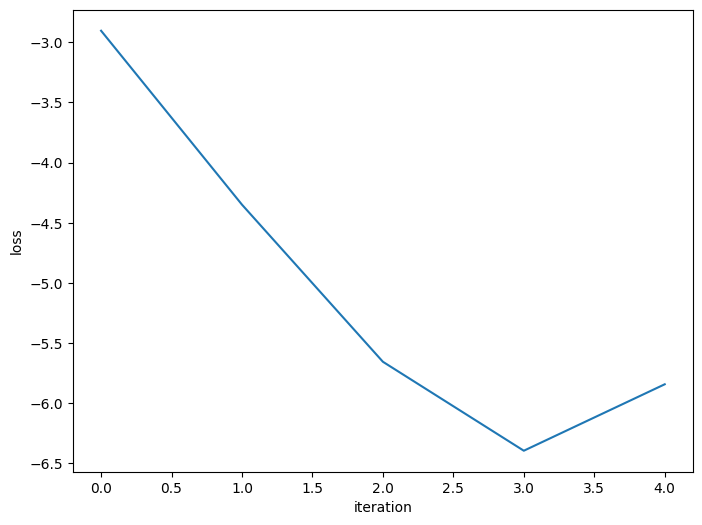

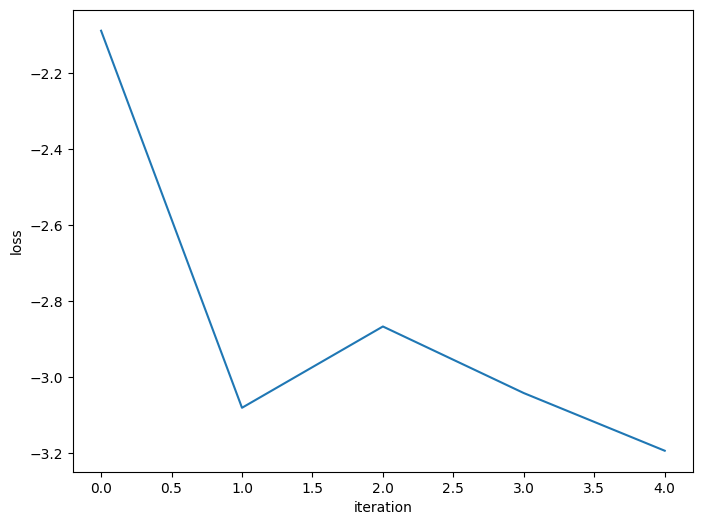

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -614.31788  validloss -524.05014±0.00000  bestvalidloss -524.05014  last_update 0
train: iter 1  trainloss -640.43080  validloss -491.52129±0.00000  bestvalidloss -524.05014  last_update 1
train: iter 2  trainloss -626.89306  validloss -515.31230±0.00000  bestvalidloss -524.05014  last_update 2
train: iter 3  trainloss -630.40039  validloss -334.40590±0.00000  bestvalidloss -524.05014  last_update 3
train: iter 4  trainloss -638.85287  validloss -519.82438±0.00000  bestvalidloss -524.05014  last_update 4
train: iter 5  trainloss -601.92813  validloss -527.69839±0.00000  bestvalidloss -527.69839  last_update 0
train: iter 6  trainloss -594.92396  validloss -525.89407±0.00000  bestvalidloss -527.69839  last_update 1
train: iter 7  trainloss -625.06304  validloss -496.71595±0.00000  bestvalidloss -527.69839  last_update 2
train: iter 8  trainloss -624.59758  validloss -520.23497±0.00000  bestvalidloss -527.69839  last_u

train: iter 76  trainloss -639.49262  validloss -534.37093±0.00000  bestvalidloss -570.54389  last_update 33
train: iter 77  trainloss -625.48756  validloss -550.66618±0.00000  bestvalidloss -570.54389  last_update 34
train: iter 78  trainloss -637.87669  validloss -519.48610±0.00000  bestvalidloss -570.54389  last_update 35
train: iter 79  trainloss -647.17323  validloss -543.57174±0.00000  bestvalidloss -570.54389  last_update 36
train: iter 80  trainloss -481.45922  validloss -548.88891±0.00000  bestvalidloss -570.54389  last_update 37
train: iter 81  trainloss 97.79347  validloss 1519.02826±0.00000  bestvalidloss -570.54389  last_update 38
train: iter 82  trainloss -530.75600  validloss -264.60098±0.00000  bestvalidloss -570.54389  last_update 39
train: iter 83  trainloss -562.07712  validloss -328.95678±0.00000  bestvalidloss -570.54389  last_update 40
train: iter 84  trainloss -570.77698  validloss -295.32045±0.00000  bestvalidloss -570.54389  last_update 41
train: iter 85  train

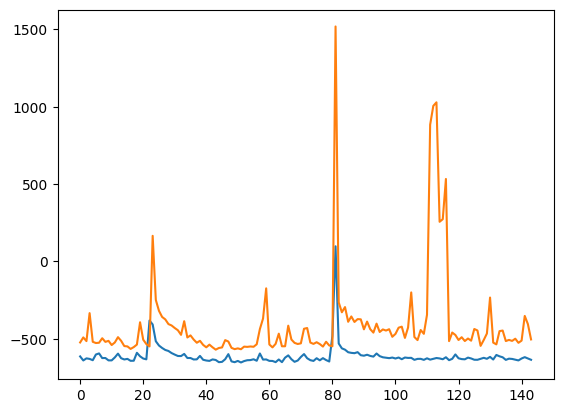

alpha 0.2 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-08-22 09:38:56.138275


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.37452  validloss 0.40563±0.00000  bestvalidloss 0.40563  last_update 0
train: iter 1  trainloss 0.35667  validloss 0.38067±0.00000  bestvalidloss 0.38067  last_update 0
train: iter 2  trainloss 0.35474  validloss 0.36352±0.00000  bestvalidloss 0.36352  last_update 0
train: iter 3  trainloss 0.35887  validloss 0.36499±0.00000  bestvalidloss 0.36352  last_update 1
train: iter 4  trainloss 0.35599  validloss 0.36255±0.00000  bestvalidloss 0.36255  last_update 0
train: iter 5  trainloss 0.34795  validloss 0.35809±0.00000  bestvalidloss 0.35809  last_update 0
train: iter 6  trainloss 0.35057  validloss 0.36422±0.00000  bestvalidloss 0.35809  last_update 1
train: iter 7  trainloss 0.34459  validloss 0.36858±0.00000  bestvalidloss 0.35809  last_update 2
train: iter 8  trainloss 0.34807  validloss 0.36777±0.00000  bestvalidloss 0.35809  last_update 3
train: iter 9  trainloss 0.34356  validloss 0.38432±0.00000  bestvalidloss 0.35809  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.32041  validloss 0.37197±0.00000  bestvalidloss 0.35809  last_update 78
train: iter 84  trainloss 0.32399  validloss 0.38316±0.00000  bestvalidloss 0.35809  last_update 79
train: iter 85  trainloss 0.32039  validloss 0.38365±0.00000  bestvalidloss 0.35809  last_update 80
train: iter 86  trainloss 0.31587  validloss 0.38619±0.00000  bestvalidloss 0.35809  last_update 81
train: iter 87  trainloss 0.32653  validloss 0.37944±0.00000  bestvalidloss 0.35809  last_update 82
train: iter 88  trainloss 0.31950  validloss 0.37695±0.00000  bestvalidloss 0.35809  last_update 83
train: iter 89  trainloss 0.32327  validloss 0.42099±0.00000  bestvalidloss 0.35809  last_update 84
train: iter 90  trainloss 0.32097  validloss 0.37701±0.00000  bestvalidloss 0.35809  last_update 85
train: iter 91  trainloss 0.31961  validloss 0.37802±0.00000  bestvalidloss 0.35809  last_update 86
train: iter 92  trainloss 0.32130  validloss 0.37379±0.00000  bestvalidloss 0.35809  last_update 87


([0.3745231721550226,
  0.3566727885976434,
  0.35474298559129236,
  0.35887451460584996,
  0.3559942077845335,
  0.3479519149288535,
  0.35056576477363705,
  0.3445874425582588,
  0.34807154461741446,
  0.34355952786281707,
  0.34335246998816726,
  0.3437739843502641,
  0.3414410397410393,
  0.3372029267251492,
  0.3343351263552904,
  0.34484801506623625,
  0.33891183603554964,
  0.35008183335885407,
  0.3403003076091409,
  0.3369133688509464,
  0.3332770992070436,
  0.3389987695030868,
  0.33490215353667735,
  0.3366917141713202,
  0.3351563489995897,
  0.3333167758770287,
  0.32938619907945393,
  0.3362468883395195,
  0.3305764408782125,
  0.3424711298197508,
  0.33095779428258537,
  0.3320116282440722,
  0.3285959240980446,
  0.3330714849755168,
  0.3270557590760291,
  0.33383610639721156,
  0.3323347883298993,
  0.3310911986976862,
  0.32783694164827465,
  0.3279635555110872,
  0.3273105833679438,
  0.32994030471891167,
  0.3328744106926024,
  0.32622524835169314,
  0.325373003911

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.847757996016741
valid_loss:  -5.650980461788178
weight_alpha 1.0 h_min_tilde -11.776587 ell_tilde -6.608402489171028 kappa_tilde 0.00021993837851101697
train_loss:  -3.3922852272510524
valid_loss:  -2.596105635929108
weight_alpha 0.2 h_min_tilde -11.776587 ell_tilde -3.2330493089866637 kappa_tilde 0.0001710610550749881


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 23.15004  validloss 25.71575±0.00000  bestvalidloss 25.71575  last_update 0
train: iter 1  trainloss 17.57629  validloss 19.79710±0.00000  bestvalidloss 19.79710  last_update 0
train: iter 2  trainloss 13.58068  validloss 14.99286±0.00000  bestvalidloss 14.99286  last_update 0
train: iter 3  trainloss 10.57741  validloss 11.54251±0.00000  bestvalidloss 11.54251  last_update 0
train: iter 4  trainloss 8.19447  validloss 8.64049±0.00000  bestvalidloss 8.64049  last_update 0
train: iter 5  trainloss 6.41536  validloss 6.90795±0.00000  bestvalidloss 6.90795  last_update 0
train: iter 6  trainloss 5.02688  validloss 5.28053±0.00000  bestvalidloss 5.28053  last_update 0
train: iter 7  trainloss 4.02794  validloss 4.26221±0.00000  bestvalidloss 4.26221  last_update 0
train: iter 8  trainloss 3.18219  validloss 3.23018±0.00000  bestvalidloss 3.23018  last_update 0
train: iter 9  trainloss 2.59697  validloss 2.60527±0.00000  bestvalidloss 2.60527  last_update 0
train: i

train: iter 84  trainloss 0.06344  validloss 0.06613±0.00000  bestvalidloss 0.01195  last_update 3
train: iter 85  trainloss 0.05756  validloss 0.03765±0.00000  bestvalidloss 0.01195  last_update 4
train: iter 86  trainloss 0.05694  validloss 0.05234±0.00000  bestvalidloss 0.01195  last_update 5
train: iter 87  trainloss 0.08025  validloss 0.05419±0.00000  bestvalidloss 0.01195  last_update 6
train: iter 88  trainloss 0.07618  validloss -0.00811±0.00000  bestvalidloss -0.00811  last_update 0
train: iter 89  trainloss 0.07636  validloss 0.03163±0.00000  bestvalidloss -0.00811  last_update 1
train: iter 90  trainloss 0.06466  validloss 0.03129±0.00000  bestvalidloss -0.00811  last_update 2
train: iter 91  trainloss 0.08352  validloss 0.08275±0.00000  bestvalidloss -0.00811  last_update 3
train: iter 92  trainloss 0.07592  validloss 0.11958±0.00000  bestvalidloss -0.00811  last_update 4
train: iter 93  trainloss 0.07820  validloss 0.08531±0.00000  bestvalidloss -0.00811  last_update 5
tra

train: iter 166  trainloss 0.09091  validloss 0.08472±0.00000  bestvalidloss -0.03233  last_update 3
train: iter 167  trainloss 0.08403  validloss 0.02283±0.00000  bestvalidloss -0.03233  last_update 4
train: iter 168  trainloss 0.06530  validloss 0.06908±0.00000  bestvalidloss -0.03233  last_update 5
train: iter 169  trainloss 0.09318  validloss 0.11816±0.00000  bestvalidloss -0.03233  last_update 6
train: iter 170  trainloss 0.08133  validloss 0.06999±0.00000  bestvalidloss -0.03233  last_update 7
train: iter 171  trainloss 0.08993  validloss 0.04126±0.00000  bestvalidloss -0.03233  last_update 8
train: iter 172  trainloss 0.08787  validloss 0.06624±0.00000  bestvalidloss -0.03233  last_update 9
train: iter 173  trainloss 0.06892  validloss 0.03238±0.00000  bestvalidloss -0.03233  last_update 10
train: iter 174  trainloss 0.08134  validloss 0.01657±0.00000  bestvalidloss -0.03233  last_update 11
train: iter 175  trainloss 0.08825  validloss -0.00824±0.00000  bestvalidloss -0.03233  l

train: iter 251  trainloss 0.09756  validloss 0.07822±0.00000  bestvalidloss -0.03233  last_update 88
train: iter 252  trainloss 0.09313  validloss 0.04787±0.00000  bestvalidloss -0.03233  last_update 89
train: iter 253  trainloss 0.06334  validloss 0.02831±0.00000  bestvalidloss -0.03233  last_update 90
train: iter 254  trainloss 0.08273  validloss 0.05755±0.00000  bestvalidloss -0.03233  last_update 91
train: iter 255  trainloss 0.09374  validloss 0.03342±0.00000  bestvalidloss -0.03233  last_update 92
train: iter 256  trainloss 0.05729  validloss 0.01562±0.00000  bestvalidloss -0.03233  last_update 93
train: iter 257  trainloss 0.06158  validloss 0.05413±0.00000  bestvalidloss -0.03233  last_update 94
train: iter 258  trainloss 0.08640  validloss 0.07623±0.00000  bestvalidloss -0.03233  last_update 95
train: iter 259  trainloss 0.08262  validloss 0.02517±0.00000  bestvalidloss -0.03233  last_update 96
train: iter 260  trainloss 0.07125  validloss 0.01195±0.00000  bestvalidloss -0.03

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-0.7150, -1.3787, -2.4755, -3.0537], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 8.42029  validloss 63.80925±0.00000  bestvalidloss 63.80925  last_update 0
train: iter 1  trainloss 7.53810  validloss 66.55888±0.00000  bestvalidloss 63.80925  last_update 1
train: iter 2  trainloss 7.37764  validloss 61.21101±0.00000  bestvalidloss 61.21101  last_update 0
train: iter 3  trainloss 7.34853  validloss 64.44056±0.00000  bestvalidloss 61.21101  last_update 1
train: iter 4  trainloss 7.38525  validloss 63.60764±0.00000  bestvalidloss 61.21101  last_update 2
train: iter 5  trainloss 7.19731  validloss 63.13622±0.00000  bestvalidloss 61.21101  last_update 3
train: iter 6  trainloss 7.16271  validloss 63.98947±0.00000  bestvalidloss 61.21101  last_update 4
train: iter 7  trainloss 7.12724  validloss 61.13155±0.00000  bestvalidloss 61.13155  last_update 0
train: iter 8  trainloss 7.12328  validloss 64.19994±0.00000  bestvalidloss 61.13155  last_update 1
train: iter 9  trainloss 7.10359  validloss 62.19008±0.00000  bestvalidloss 61.13155  last_update 2


train: iter 83  trainloss 6.76038  validloss 56.35852±0.00000  bestvalidloss 55.11321  last_update 70
train: iter 84  trainloss 6.73885  validloss 62.32875±0.00000  bestvalidloss 55.11321  last_update 71
train: iter 85  trainloss 6.70735  validloss 71.36867±0.00000  bestvalidloss 55.11321  last_update 72
train: iter 86  trainloss 6.83261  validloss 59.18142±0.00000  bestvalidloss 55.11321  last_update 73
train: iter 87  trainloss 6.85794  validloss 61.27858±0.00000  bestvalidloss 55.11321  last_update 74
train: iter 88  trainloss 6.81737  validloss 56.21941±0.00000  bestvalidloss 55.11321  last_update 75
train: iter 89  trainloss 6.77481  validloss 58.34758±0.00000  bestvalidloss 55.11321  last_update 76
train: iter 90  trainloss 6.79561  validloss 58.55072±0.00000  bestvalidloss 55.11321  last_update 77
train: iter 91  trainloss 6.79212  validloss 63.07744±0.00000  bestvalidloss 55.11321  last_update 78
train: iter 92  trainloss 6.70519  validloss 59.04042±0.00000  bestvalidloss 55.11

train: iter 163  trainloss 6.67384  validloss 62.55059±0.00000  bestvalidloss 54.24510  last_update 52
train: iter 164  trainloss 6.72106  validloss 60.20715±0.00000  bestvalidloss 54.24510  last_update 53
train: iter 165  trainloss 6.70851  validloss 60.85400±0.00000  bestvalidloss 54.24510  last_update 54
train: iter 166  trainloss 6.70217  validloss 62.15113±0.00000  bestvalidloss 54.24510  last_update 55
train: iter 167  trainloss 6.64307  validloss 60.64044±0.00000  bestvalidloss 54.24510  last_update 56
train: iter 168  trainloss 6.65108  validloss 63.14056±0.00000  bestvalidloss 54.24510  last_update 57
train: iter 169  trainloss 6.72296  validloss 64.25278±0.00000  bestvalidloss 54.24510  last_update 58
train: iter 170  trainloss 6.71005  validloss 64.59240±0.00000  bestvalidloss 54.24510  last_update 59
train: iter 171  trainloss 6.67179  validloss 59.91837±0.00000  bestvalidloss 54.24510  last_update 60
train: iter 172  trainloss 6.74927  validloss 60.87660±0.00000  bestvalid

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-7.6228)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(21.0360)


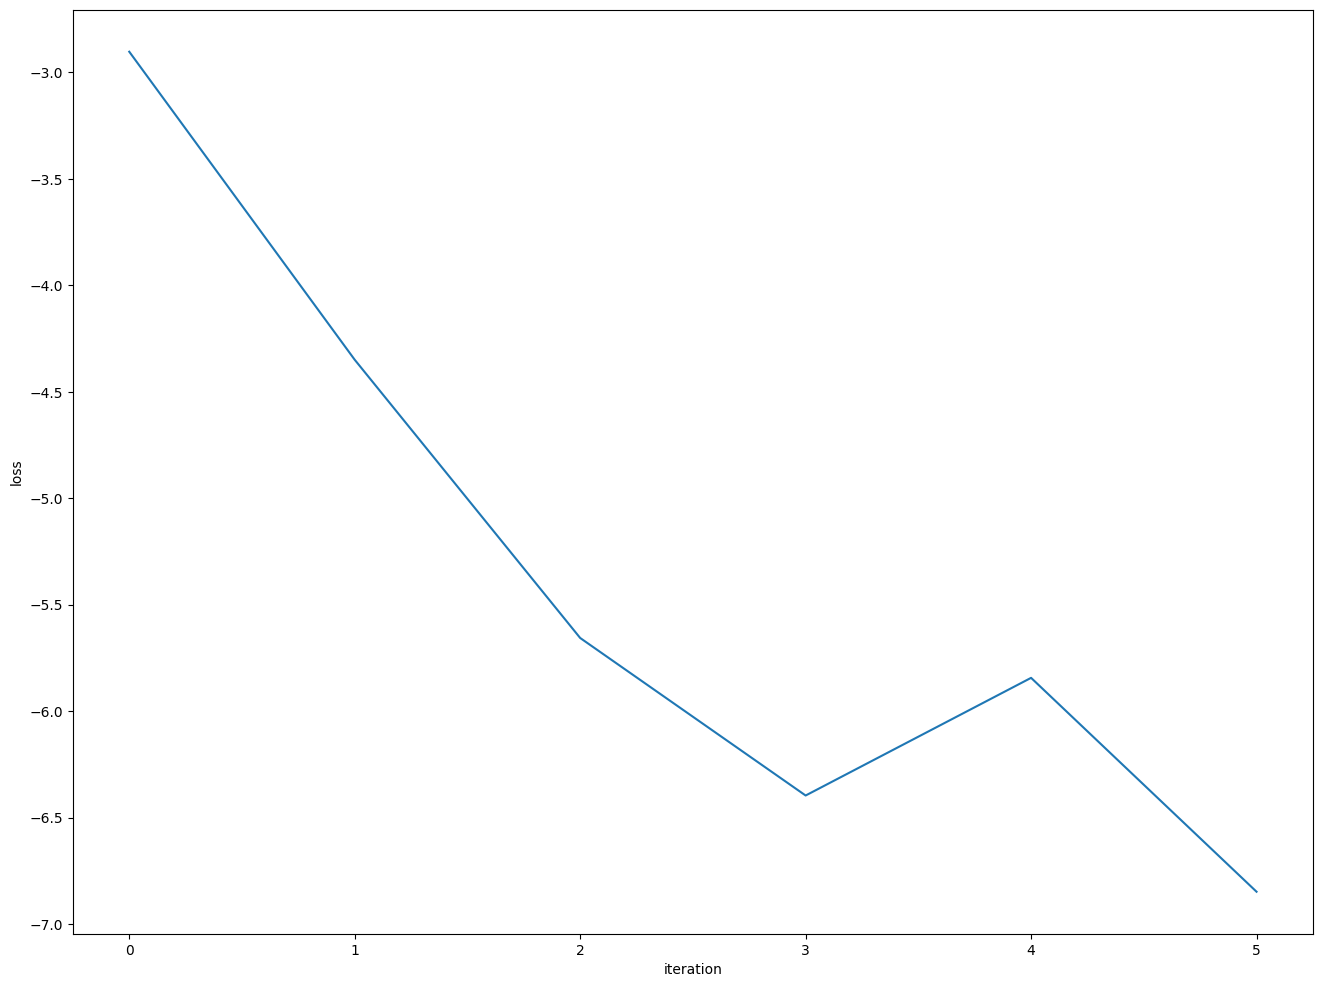

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

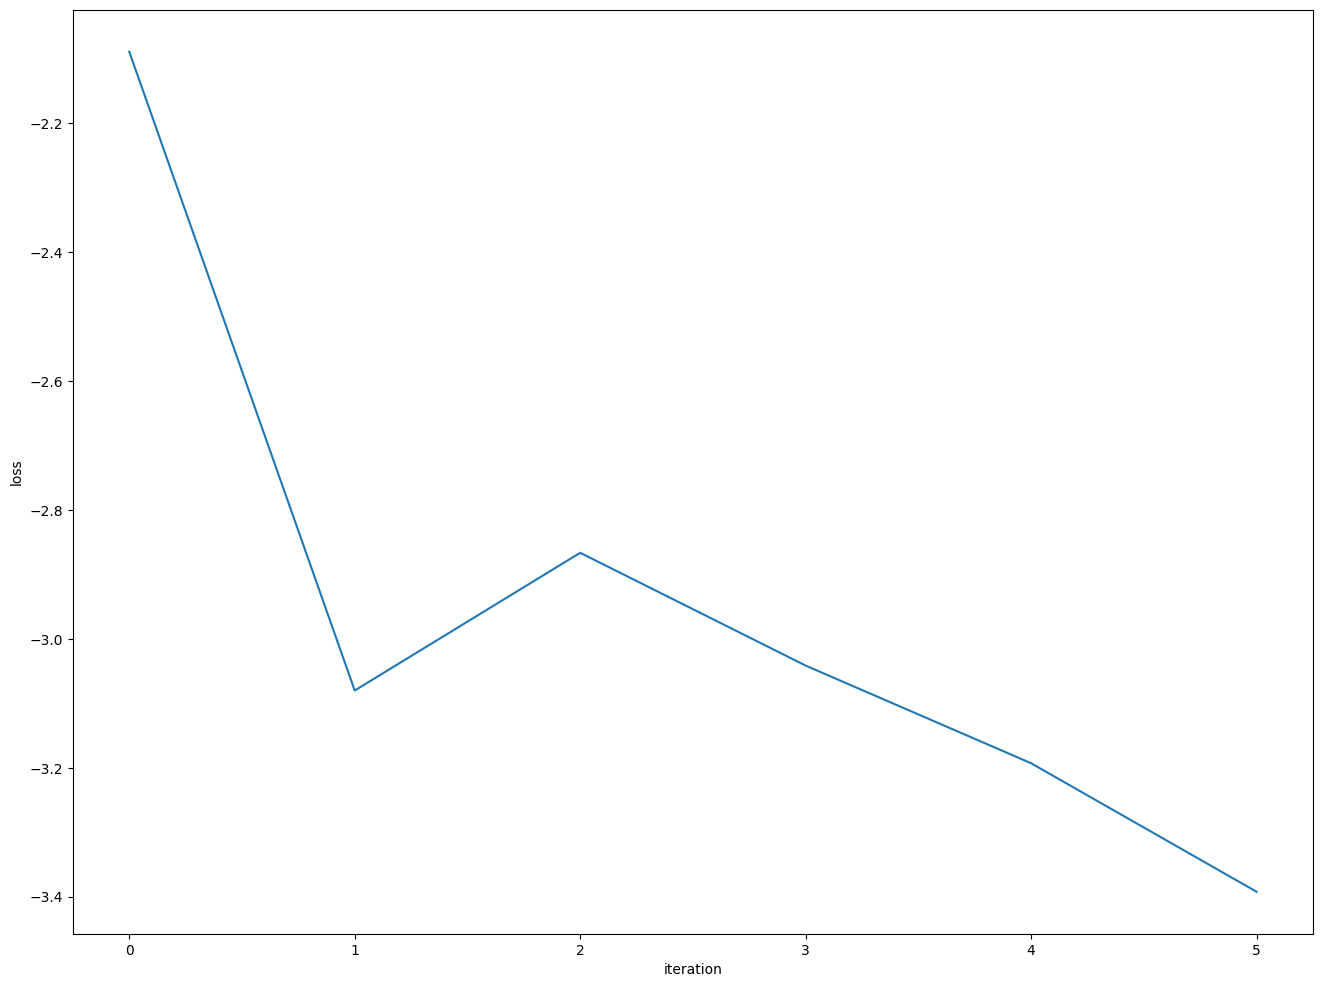

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")